In [1]:
"""
One brick in the hierachy for an industrial ethylene-oxide reactor

© 2023. Triad National Security, LLC. All rights reserved.
This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos
National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S.
Department of Energy/National Nuclear Security Administration. All rights in the program are.
reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear
Security Administration. The Government is granted for itself and others acting on its behalf a
nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare.
derivative works, distribute copies to the public, perform publicly and display publicly, and to permit.
others to do so.

@author: Sean T. Smith, Oct. 2022
"""

from numpy import array, empty, ones, linspace, sqrt, log, exp
from numpy.linalg import solve, eigh
from numba import jit

from scipy.optimize import minimize

from pandas import DataFrame

%matplotlib inline
import matplotlib.pyplot as plt

# Fit different models to Klugherz data
This is just a rough exploration of different possibilities for different forms of the rate expression. Here, I take the subsets of the problem and visualize the model checking of the posterior mode — roughly just a least-squares run through of some different options.

# Just the epoxidation
Based on the experimental data reported by [Klugherz & Harriott](references/Klugherz1971-EthyleneOx.pdf). Digitation was copied from the [EthyleneOxRates-Literature notebook](EthyleneOxRates-Literature.ipynb).

In [2]:
Po = array([1.32, 1.05, 0.789, 0.526, 0.263, 0.132, 0.061])
Pe = [[0.0283, 0.0632, 0.1265],  # Po = 1.32 atm
      [0.0616, 0.1281, 0.2596, 0.5191],  # Po = 1.05 atm
      [0.0266, 0.0616, 0.1298, 0.2596, 0.5208, 0.7837],  # Po = 0.789 atm
      [0.0582, 0.1314, 0.2596, 0.5208, 0.7854, 1.0466],  # Po = 0.526 atm
      [0.0300, 0.0649, 0.1314, 0.2612, 0.5258, 0.7870, 1.0516, 1.3228],  # Po = 0.263 atm
      [0.0632, 0.1348, 0.2612, 0.5275, 0.7887, 1.0516, 1.3211],  # Po = 0.132 atm
      [0.0616, 0.1298, 0.2629, 0.5225, 1.0483]]  # Po = 0.061 atm
Pe_alt = [[0.0274, 0.0670, 0.1309],  # Po = 1.32 atm
      [0.0639, 0.1309, 0.2587, 0.5204],  # Po = 1.05 atm
      [0.0274, 0.0639, 0.1309, 0.2557, 0.5204, 0.7822],  # Pi = 0.789 atm
      [0.0670, 0.1309, 0.2617, 0.5235, 0.7883, 1.0470],  # Po = 0.526 atm
      [0.0274, 0.0670, 0.1309, 0.2648, 0.5265, 0.7852, 1.0470, 1.3178],  # Po = 0.263 atm
      [0.0670, 0.1309, 0.2678, 0.5265, 0.7883, 1.0500, 1.3178],  # Po = 0.132 atm
      [0.0670, 0.1339, 0.2648, 0.5265, 1.05]]  # Po = 0.061 atm
R0 = [[0.5811, 1.2467, 1.9719],  # Po = 1.32 atm
      [1.1540, 1.8328, 2.5513, 3.1440],  # Po = 1.05 atm
      [0.5149, 1.0745, 1.4851, 2.1474, 2.5679, 2.3791],  # Po = 0.789 atm
      [0.8990, 1.2070, 1.6209, 1.7997, 1.6672, 1.6076],  # Po = 0.526 atm
      [0.3195, 0.6076, 0.8162, 1.0050, 0.9652, 0.8725, 0.7202, 0.6970],  # Po = 0.263 atm
      [0.3907, 0.5232, 0.5960, 0.5199, 0.4305, 0.3560, 0.2930],  # Po = 0.132 atm
      [0.2318, 0.3146, 0.2980, 0.2252, 0.1192]]  # Po = 0.61 atm
R1 = [[0.5082, 1.1327, 2.0755],  # Po = 1.32 atm
      [1.1633, 1.8000, 2.4000, 2.6265],  # Po = 1.05 atm
      [0.4776, 1.0469, 1.5490, 2.0816, 2.1612, 1.7633],  # Po = 0.789 atm
      [0.9612, 1.3224, 1.6286, 1.4571, 1.2000, 1.0592],  # Po = 0.526 atm
      [0.3735, 0.7592, 1.0041, 0.9980, 0.7531, 0.6367, 0.4776, 0.4469],  # Po = 0.263 atm
      [0.5571, 0.6429, 0.6000, 0.4041, 0.3000, 0.2388, 0.1837],  # Po = 0.132 atm
      [0.3551, 0.4041, 0.3061, 0.1959, 0.1163]]  # Po = 0.061 atm
expt = []
for i in range(Po.shape[0]):
    for j in range(len(Pe[i])):
        expt.append([(Pe[i][j] + Pe_alt[i][j]) / 2, Po[i], 220 + 273.15, R0[i][j], R1[i][j]])

Pe = array([0.526, 0.263, 0.132, 0.066, 0.026, 0.789, 1.05, 1.32])
Po = [[0.0598, 0.1312, 0.2625, 0.5266, 0.7890, 1.0548],  # Pe = 0.526 atm
      [0.1296, 0.2641, 0.5249, 0.7890, 1.0498],  # Pe = 0.263 atm
      [0.0598, 0.2608, 0.5249, 0.7890, 1.0532, 1.3239],  # Pe = 0.132 atm
      [0.1279, 0.2625, 0.5249, 0.7890, 1.0515, 1.3189],  # Pe = 0.066 atm
      [0.2608, 0.7874, 1.3189],  # Pe = 0.026 atm
      [0.1321, 0.2659, 0.5286, 0.7912],  # Pe = 0.789 atm
      [0.0652, 0.1338, 0.2659, 0.5319],  # Pe = 1.05 atm
      [0.1355, 0.2659]]  # Pe = 1.32 atm
R0 = [[0.2289, 0.5417, 0.9731, 1.8128, 2.5735, 3.1465],  # Pe = 0.526 atm
      [0.6043, 1.0258, 1.6317, 2.1520, 2.5670],  # Pe = 0.263 atm
      [0.3178, 0.8150, 1.2168, 1.4967, 1.8425, 1.9808],  # Pe = 0.132 atm
      [0.4001, 0.6240, 0.9138, 1.0851, 1.1608, 1.2530],  # Pe = 0.066 atm
      [0.3342, 0.5318, 0.5812],  # Pe = 0.026 atm
      [0.4437, 0.8808, 1.6788, 2.3775],  # Pe = 0.789 atm
      [0.1291, 0.3642, 0.7384, 1.6192],  # Pe = 1.05 atm
      [0.2947, 0.6954]]  # Pe = 1.32 atm

for i in range(Pe.shape[0]):
    for j in range(len(Po[i])):
        expt.append([Pe[i], Po[i][j], 220 + 273.15, R0[i][j], None])


In [3]:
col_labels = ['Pres. C2H4 [atm]', 'Pres. O2 [atm]', 'Temp. [K]', 'rel. rate C2H4O [-]', 'rel. rate CO2 [-]']
expt_df = DataFrame(expt, columns=col_labels)
expt_df

,Pres. C2H4 [atm],Pres. O2 [atm],Temp. [K],rel. rate C2H4O [-],rel. rate CO2 [-]
0,0.02785,1.3200,493.15,0.5811,0.5082
1,0.06510,1.3200,493.15,1.2467,1.1327
2,0.12870,1.3200,493.15,1.9719,2.0755
3,0.06275,1.0500,493.15,1.1540,1.1633
4,0.12950,1.0500,493.15,1.8328,1.8000
...,...,...,...,...,...
70,1.05000,0.1338,493.15,0.3642,NaN
71,1.05000,0.2659,493.15,0.7384,NaN
72,1.05000,0.5319,493.15,1.6192,NaN
73,1.32000,0.1355,493.15,0.2947,NaN


## Try: all sites, atomic-oxygen adsorption, simple Langmuir, variable-order rxn.

In [4]:
Pe = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po = expt_df['Pres. O2 [atm]'].to_numpy()
y = expt_df['rel. rate C2H4O [-]'].to_numpy()
Pe0 = 0.263
Po0 = 0.263
Ke = 1.38
Ko = 5.40
G = array([log(Pe / Pe0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0)) / (1 + Ke * Pe + sqrt(Ko * Po))),
     0.5 * log(Po / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0)) / (1 + Ke * Pe + sqrt(Ko * Po)))]).T
x = solve(G.T @ G, G.T @ log(y))
print(x)

[0.71541359 3.25834968]


In [5]:
Pe = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po = expt_df['Pres. O2 [atm]'].to_numpy()
y = expt_df['rel. rate C2H4O [-]'].to_numpy()
ne = y.shape[0]
# @jit(nopython=True)
def nln_post(ϕ):
    Ke = ϕ[0]
    Ko = ϕ[1]
    σ = ϕ[2]
    # Prior
    nln_prior = log(σ)
    # Likelihood
    G = empty((ne, 3))
    G[:, 0] = ones(ne)
    G[:, 1] = log(Ke * Pe / (1 + Ke * Pe + sqrt(Ko * Po)))
    G[:, 2] = log(sqrt(Ko * Po) / (1 + Ke * Pe + sqrt(Ko * Po)))
    Λ, V = eigh(G.T @ G)
    xbar = V @ (((log(y).T @ G) @ V) / Λ).T
    ln_detGTG = log(Λ).sum()
    δ = log(y) - G @ xbar
    nln_likelihood = 0.5 * (ln_detGTG + δ.T @ δ / σ**2) + (ne - 3) * log(σ)
    # Posterior
    nln_posterior = nln_prior + nln_likelihood
    return nln_posterior
ϕ_guess = array([1, 1, 0.3])
# nln_post(ϕ_guess)

out = minimize(nln_post, ϕ_guess, bounds=((1e-5, None),)*3, method='Nelder-Mead', options=dict(maxiter=1000))
for term in ['success', 'message', 'x', 'fun']:
    print(term, out[term])

success True
message Optimization terminated successfully.
x [1.38279449 5.40042838 0.08438572]
fun -138.9005774194229


In [6]:
Ke = 1.38
Ko = 5.40
xbar = array([0.72, 3.26])

/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/1115154332.py:29: RuntimeWarning: divide by zero encountered in log
  G = array([log(Pe    / Pe0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0)) / (1 + Ke * Pe + sqrt(Ko * Po[i]))),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/1115154332.py:63: RuntimeWarning: divide by zero encountered in log
  0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0)) / (1 + Ke * Pe[i] + sqrt(Ko * Po)))]).T
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/1115154332.py:93: RuntimeWarning: divide by zero encountered in log
  0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0)) / (1 + Ke * Pe[i] + sqrt(Ko * Po)))]).T


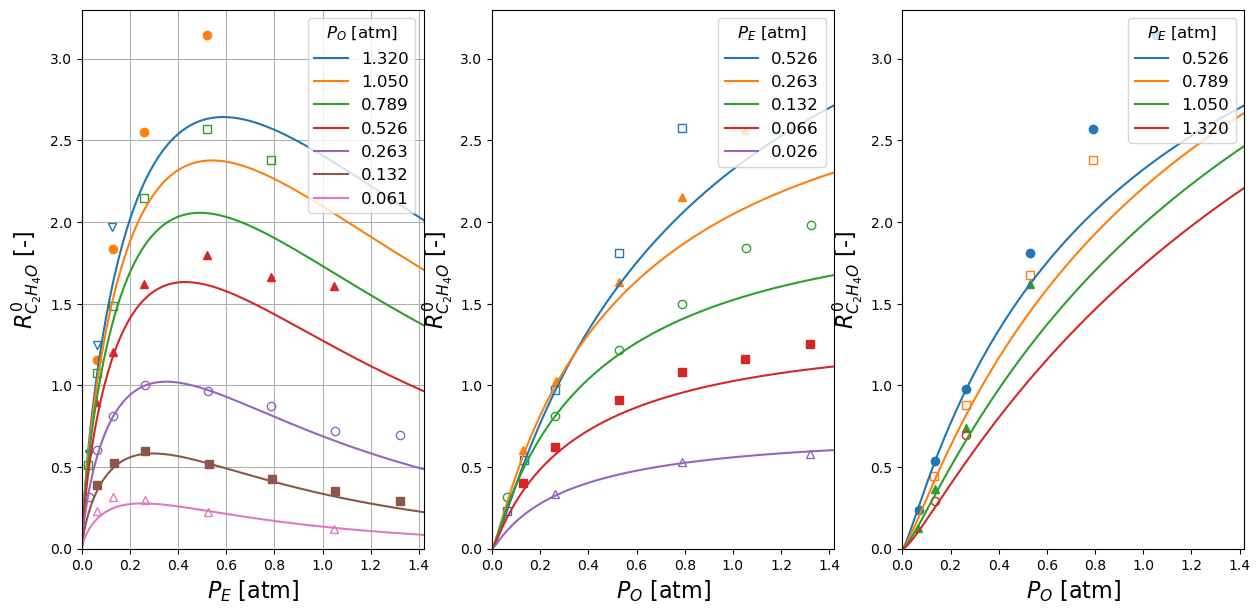

In [7]:
# Rate of production of ethylene oxide at various pressures of ethylene & oxygen — experiment & theory:
plt.figure(figsize=(15, 7))

# Compare to Figs. 3 & 12
plt.subplot(1, 3, 1)
Po = array([1.32, 1.05, 0.789, 0.526, 0.263, 0.132, 0.061])
Pe = [[0.0283, 0.0632, 0.1265],  # Po = 1.32 atm
      [0.0616, 0.1281, 0.2596, 0.5191],  # Po = 1.05 atm
      [0.0266, 0.0616, 0.1298, 0.2596, 0.5208, 0.7837],  # Po = 0.789 atm
      [0.0582, 0.1314, 0.2596, 0.5208, 0.7854, 1.0466],  # Po = 0.526 atm
      [0.0300, 0.0649, 0.1314, 0.2612, 0.5258, 0.7870, 1.0516, 1.3228],  # Po = 0.263 atm
      [0.0632, 0.1348, 0.2612, 0.5275, 0.7887, 1.0516, 1.3211],  # Po = 0.132 atm
      [0.0616, 0.1298, 0.2629, 0.5225, 1.0483]]  # Po = 0.061 atm
R0 = [[0.5811, 1.2467, 1.9719],  # Po = 1.32 atm
      [1.1540, 1.8328, 2.5513, 3.1440],  # Po = 1.05 atm
      [0.5149, 1.0745, 1.4851, 2.1474, 2.5679, 2.3791],  # Po = 0.789 atm
      [0.8990, 1.2070, 1.6209, 1.7997, 1.6672, 1.6076],  # Po = 0.526 atm
      [0.3195, 0.6076, 0.8162, 1.0050, 0.9652, 0.8725, 0.7202, 0.6970],  # Po = 0.263 atm
      [0.3907, 0.5232, 0.5960, 0.5199, 0.4305, 0.3560, 0.2930],  # Po = 0.132 atm
      [0.2318, 0.3146, 0.2980, 0.2252, 0.1192]]  # Po = 0.61 atm      
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    plt.plot(Pe[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe = linspace(0, 1.42, 200)  # atm
R0 = empty((Po.shape[0], Pe.shape[0]))
for i in range(Po.shape[0]):
    G = array([log(Pe    / Pe0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0)) / (1 + Ke * Pe + sqrt(Ko * Po[i]))),
         0.5 * log(Po[i] / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0)) / (1 + Ke * Pe + sqrt(Ko * Po[i])))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Pe, R0[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe[0], Pe[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.grid(True)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 4
plt.subplot(1, 3, 2) 
Pe = array([0.526, 0.263, 0.132, 0.066, 0.026])
Po = [[0.0598, 0.1312, 0.2625, 0.5266, 0.7890, 1.0548],  # Pe = 0.526 atm
      [0.1296, 0.2641, 0.5249, 0.7890, 1.0498],  # Pe = 0.263 atm
      [0.0598, 0.2608, 0.5249, 0.7890, 1.0532, 1.3239],  # Pe = 0.132 atm
      [0.1279, 0.2625, 0.5249, 0.7890, 1.0515, 1.3189],  # Pe = 0.066 atm
      [0.2608, 0.7874, 1.3189]]  # Pe = 0.026 atm
R0 = [[0.2289, 0.5417, 0.9731, 1.8128, 2.5735, 3.1465],  # Pe = 0.526 atm
      [0.6043, 1.0258, 1.6317, 2.1520, 2.5670],  # Pe = 0.263 atm
      [0.3178, 0.8150, 1.2168, 1.4967, 1.8425, 1.9808],  # Pe = 0.132 atm
      [0.4001, 0.6240, 0.9138, 1.0851, 1.1608, 1.2530],  # Pe = 0.066 atm
      [0.3342, 0.5318, 0.5812]]  # Pe = 0.026 atm
marker = ['s', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0)) / (1 + Ke * Pe[i] + sqrt(Ko * Po))),
         0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0)) / (1 + Ke * Pe[i] + sqrt(Ko * Po)))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 5
plt.subplot(1, 3, 3) 
Pe = array([0.526, 0.789, 1.05, 1.32])
Po = [[0.0669, 0.1355, 0.2659, 0.5286, 0.7928, 1.0538],  # Pe = 0.526 atm
      [0.1321, 0.2659, 0.5286, 0.7912],  # Pe = 0.789 atm
      [0.0652, 0.1338, 0.2659, 0.5319],  # Pe = 1.05 atm
      [0.1355, 0.2659]]  # Pe = 1.32 atm
R0 = [[0.2384, 0.5364, 0.9801, 1.8113, 2.5695, 3.1457],  # Pe = 0.526 atm
      [0.4437, 0.8808, 1.6788, 2.3775],  # Pe = 0.789 atm
      [0.1291, 0.3642, 0.7384, 1.6192],  # Pe = 1.05 atm
      [0.2947, 0.6954]]  # Pe = 1.32 atm
marker = ['o', 's', '^', 'o']
face = [None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)  # atm
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0)) / (1 + Ke * Pe[i] + sqrt(Ko * Po))),
         0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0)) / (1 + Ke * Pe[i] + sqrt(Ko * Po)))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right');

## Try: elemental-oxygen-activated sites, molecular-oxygen adsorption, simple Langmuir, variable-order rxn.

In [8]:
Pe = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po = expt_df['Pres. O2 [atm]'].to_numpy()
y = expt_df['rel. rate C2H4O [-]'].to_numpy()
Pe0 = 0.263
Po0 = 0.263
Ke = 15
Ko = 6.8
Ks = 0.0
Cp = 0.01
G = array([log(Pe / Pe0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe + Ko * Po) * sqrt(Po/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po))),
           log(Po / Po0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe + Ko * Po) * sqrt(Po/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po)))]).T
x = solve(G.T @ G, G.T @ log(y))
print(x)

[0.84160102 0.53056684]


In [9]:
Pe = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po = expt_df['Pres. O2 [atm]'].to_numpy()
y = expt_df['rel. rate C2H4O [-]'].to_numpy()
ne = y.shape[0]
# @jit(nopython=True)
def nln_post(ϕ):
    Ke = ϕ[0]
    Ko = ϕ[1]
    Ks = ϕ[2]
    Cp = ϕ[3]
    σ = ϕ[4]
    # Prior
    nln_prior = log(σ)
    # Likelihood
    G = empty((ne, 2))
    G[:, 0] = log(Pe / Pe0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe + Ko * Po) * sqrt(Po/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po)))
    G[:, 1] = log(Po / Po0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe + Ko * Po) * sqrt(Po/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po)))
    Λ, V = eigh(G.T @ G)
    xbar = V @ (((log(y).T @ G) @ V) / Λ).T
    ln_detGTG = log(Λ).sum()
    δ = log(y) - G @ xbar
    nln_likelihood = 0.5 * (ln_detGTG + δ.T @ δ / σ**2) + (ne - 3) * log(σ)
    # Posterior
    nln_posterior = nln_prior + nln_likelihood
    return nln_posterior
ϕ_guess = array([1, 1, 1, 0.1, 0.3])
# nln_post(ϕ_guess)

out = minimize(nln_post, ϕ_guess, bounds=((1e-8, None),)*5, method='Nelder-Mead', options=dict(maxiter=1000))
for term in ['success', 'message', 'x', 'fun']:
    print(term, out[term])

success True
message Optimization terminated successfully.
x [1.50672015e+01 6.77577252e+00 1.00000000e-08 9.65931497e-03
 1.07944431e-01]
fun -121.74814953958506


In [10]:
Pe0 = 0.263
Po0 = 0.263
Ke = 15
Ko = 6.7
Ks = 0.0
Cp = 0.01
xbar = array([0.84, 0.53])

/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3942101040.py:29: RuntimeWarning: divide by zero encountered in log
  G = array([log(Pe    / Pe0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe + Ko * Po[i]) * sqrt(Po[i]/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po[i]))),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3942101040.py:62: RuntimeWarning: divide by zero encountered in log
  G = array([log(Pe[i] / Pe0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe[i] + Ko * Po) * sqrt(Po/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po))),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3942101040.py:63: RuntimeWarning: divide by zero encountered in log
  log(Po    / Po0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe[i] + Ko * Po) * sqrt(Po/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po)))]).T
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3942101040.py:92: RuntimeWarning: divide by zero encountered in log
  G = array

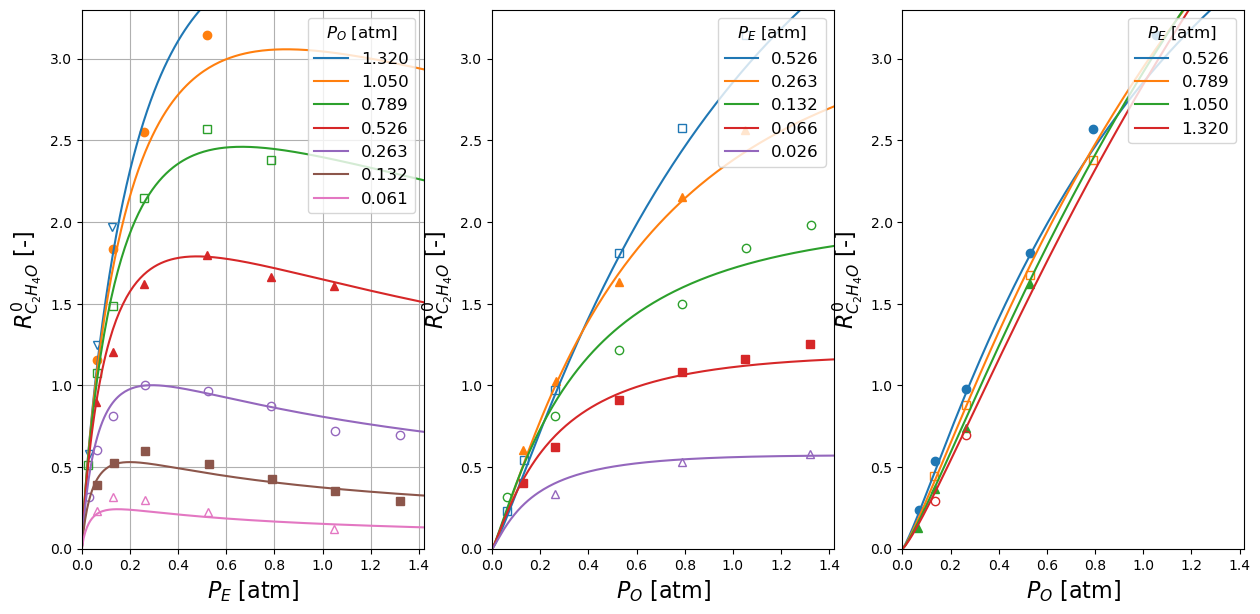

In [11]:
# Rate of production of ethylene oxide at various pressures of ethylene & oxygen — experiment & theory:
plt.figure(figsize=(15, 7))

# Compare to Figs. 3 & 12
plt.subplot(1, 3, 1)
Po = array([1.32, 1.05, 0.789, 0.526, 0.263, 0.132, 0.061])
Pe = [[0.0283, 0.0632, 0.1265],  # Po = 1.32 atm
      [0.0616, 0.1281, 0.2596, 0.5191],  # Po = 1.05 atm
      [0.0266, 0.0616, 0.1298, 0.2596, 0.5208, 0.7837],  # Po = 0.789 atm
      [0.0582, 0.1314, 0.2596, 0.5208, 0.7854, 1.0466],  # Po = 0.526 atm
      [0.0300, 0.0649, 0.1314, 0.2612, 0.5258, 0.7870, 1.0516, 1.3228],  # Po = 0.263 atm
      [0.0632, 0.1348, 0.2612, 0.5275, 0.7887, 1.0516, 1.3211],  # Po = 0.132 atm
      [0.0616, 0.1298, 0.2629, 0.5225, 1.0483]]  # Po = 0.061 atm
R0 = [[0.5811, 1.2467, 1.9719],  # Po = 1.32 atm
      [1.1540, 1.8328, 2.5513, 3.1440],  # Po = 1.05 atm
      [0.5149, 1.0745, 1.4851, 2.1474, 2.5679, 2.3791],  # Po = 0.789 atm
      [0.8990, 1.2070, 1.6209, 1.7997, 1.6672, 1.6076],  # Po = 0.526 atm
      [0.3195, 0.6076, 0.8162, 1.0050, 0.9652, 0.8725, 0.7202, 0.6970],  # Po = 0.263 atm
      [0.3907, 0.5232, 0.5960, 0.5199, 0.4305, 0.3560, 0.2930],  # Po = 0.132 atm
      [0.2318, 0.3146, 0.2980, 0.2252, 0.1192]]  # Po = 0.61 atm      
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    plt.plot(Pe[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe = linspace(0, 1.42, 200)  # atm
R0 = empty((Po.shape[0], Pe.shape[0]))
for i in range(Po.shape[0]):
    G = array([log(Pe    / Pe0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe + Ko * Po[i]) * sqrt(Po[i]/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po[i]))),
               log(Po[i] / Po0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe + Ko * Po[i]) * sqrt(Po[i]/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po[i])))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Pe, R0[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe[0], Pe[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.grid(True)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 4
plt.subplot(1, 3, 2) 
Pe = array([0.526, 0.263, 0.132, 0.066, 0.026])
Po = [[0.0598, 0.1312, 0.2625, 0.5266, 0.7890, 1.0548],  # Pe = 0.526 atm
      [0.1296, 0.2641, 0.5249, 0.7890, 1.0498],  # Pe = 0.263 atm
      [0.0598, 0.2608, 0.5249, 0.7890, 1.0532, 1.3239],  # Pe = 0.132 atm
      [0.1279, 0.2625, 0.5249, 0.7890, 1.0515, 1.3189],  # Pe = 0.066 atm
      [0.2608, 0.7874, 1.3189]]  # Pe = 0.026 atm
R0 = [[0.2289, 0.5417, 0.9731, 1.8128, 2.5735, 3.1465],  # Pe = 0.526 atm
      [0.6043, 1.0258, 1.6317, 2.1520, 2.5670],  # Pe = 0.263 atm
      [0.3178, 0.8150, 1.2168, 1.4967, 1.8425, 1.9808],  # Pe = 0.132 atm
      [0.4001, 0.6240, 0.9138, 1.0851, 1.1608, 1.2530],  # Pe = 0.066 atm
      [0.3342, 0.5318, 0.5812]]  # Pe = 0.026 atm
marker = ['s', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe[i] + Ko * Po) * sqrt(Po/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po))),
               log(Po    / Po0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe[i] + Ko * Po) * sqrt(Po/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po)))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 5
plt.subplot(1, 3, 3) 
Pe = array([0.526, 0.789, 1.05, 1.32])
Po = [[0.0669, 0.1355, 0.2659, 0.5286, 0.7928, 1.0538],  # Pe = 0.526 atm
      [0.1321, 0.2659, 0.5286, 0.7912],  # Pe = 0.789 atm
      [0.0652, 0.1338, 0.2659, 0.5319],  # Pe = 1.05 atm
      [0.1355, 0.2659]]  # Pe = 1.32 atm
R0 = [[0.2384, 0.5364, 0.9801, 1.8113, 2.5695, 3.1457],  # Pe = 0.526 atm
      [0.4437, 0.8808, 1.6788, 2.3775],  # Pe = 0.789 atm
      [0.1291, 0.3642, 0.7384, 1.6192],  # Pe = 1.05 atm
      [0.2947, 0.6954]]  # Pe = 1.32 atm
marker = ['o', 's', '^', 'o']
face = [None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)  # atm
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe[i] + Ko * Po) * sqrt(Po/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po))),
               log(Po    / Po0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe[i] + Ko * Po) * sqrt(Po/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po)))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right');

## Testing a simplification

In [12]:
Pe = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po = expt_df['Pres. O2 [atm]'].to_numpy()
y = expt_df['rel. rate C2H4O [-]'].to_numpy()
Pe0 = 0.263
Po0 = 0.263
Ke = 15
Ko = 6.8
Cp = 0.0
G = array([log(Pe / Pe0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po + Cp) * sqrt(Po/Po0)),
           log(Po / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po + Cp) * sqrt(Po/Po0))]).T
x = solve(G.T @ G, G.T @ log(y))
print(x)

[0.84160102 0.53056684]


In [13]:
Pe = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po = expt_df['Pres. O2 [atm]'].to_numpy()
y = expt_df['rel. rate C2H4O [-]'].to_numpy()
ne = y.shape[0]
# @jit(nopython=True)
def nln_post(ϕ):
    Ke = ϕ[0]
    Ko = ϕ[1]
    Cp = ϕ[2]
    σ = ϕ[3]
    # Prior
    nln_prior = log(σ)
    # Likelihood
    G = empty((ne, 2))
    G[:, 0] = log(Pe / Pe0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po + Cp) * sqrt(Po/Po0))
    G[:, 1] = log(Po / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po + Cp) * sqrt(Po/Po0))
    Λ, V = eigh(G.T @ G)
    xbar = V @ (((log(y).T @ G) @ V) / Λ).T
    ln_detGTG = log(Λ).sum()
    δ = log(y) - G @ xbar
    nln_likelihood = 0.5 * (ln_detGTG + δ.T @ δ / σ**2) + (ne - 3) * log(σ)
    # Posterior
    nln_posterior = nln_prior + nln_likelihood
    return nln_posterior
ϕ_guess = array([1, 1, 0.1, 0.3])
# nln_post(ϕ_guess)

out = minimize(nln_post, ϕ_guess, bounds=((1e-8, None),)*4, method='Nelder-Mead', options=dict(maxiter=1000))
for term in ['success', 'message', 'x', 'fun']:
    print(term, out[term])

success True
message Optimization terminated successfully.
x [1.50686683e+01 6.77752891e+00 1.00000000e-08 1.07941668e-01]
fun -121.75019058880969


In [14]:
Pe0 = 0.263
Po0 = 0.263
Ke = 15
Ko = 6.8
Cp = 0.0
xbar = array([0.84, 0.53])

/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3263871728.py:29: RuntimeWarning: divide by zero encountered in log
  G = array([log(Pe    / Pe0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po[i] + Cp) * sqrt(Po[i] / Po0)),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3263871728.py:62: RuntimeWarning: divide by zero encountered in log
  G = array([log(Pe[i] / Pe0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe[i] + Ko * Po + Cp) * sqrt(Po / Po0)),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3263871728.py:63: RuntimeWarning: divide by zero encountered in log
  log(Po    / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe[i] + Ko * Po + Cp) * sqrt(Po / Po0))]).T
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3263871728.py:92: RuntimeWarning: divide by zero encountered in log
  G = array([log(Pe[i] / Pe0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe[i] + Ko * Po) * sqrt(Po/Po0) * (1 + 

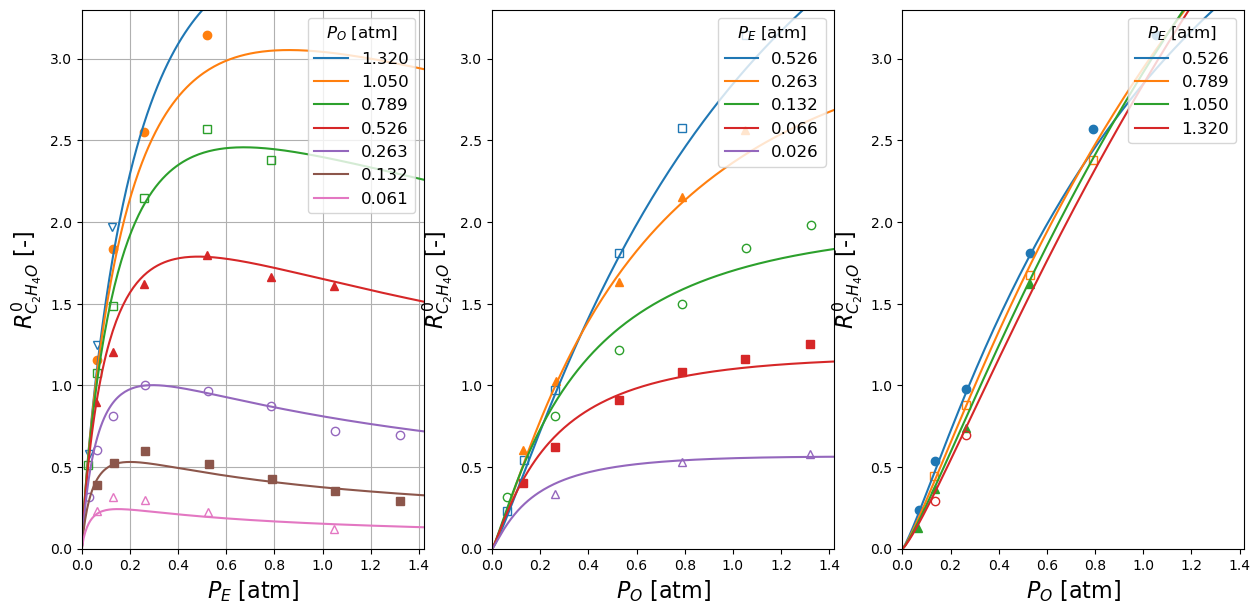

In [15]:
# Rate of production of ethylene oxide at various pressures of ethylene & oxygen — experiment & theory:
plt.figure(figsize=(15, 7))

# Compare to Figs. 3 & 12
plt.subplot(1, 3, 1)
Po = array([1.32, 1.05, 0.789, 0.526, 0.263, 0.132, 0.061])
Pe = [[0.0283, 0.0632, 0.1265],  # Po = 1.32 atm
      [0.0616, 0.1281, 0.2596, 0.5191],  # Po = 1.05 atm
      [0.0266, 0.0616, 0.1298, 0.2596, 0.5208, 0.7837],  # Po = 0.789 atm
      [0.0582, 0.1314, 0.2596, 0.5208, 0.7854, 1.0466],  # Po = 0.526 atm
      [0.0300, 0.0649, 0.1314, 0.2612, 0.5258, 0.7870, 1.0516, 1.3228],  # Po = 0.263 atm
      [0.0632, 0.1348, 0.2612, 0.5275, 0.7887, 1.0516, 1.3211],  # Po = 0.132 atm
      [0.0616, 0.1298, 0.2629, 0.5225, 1.0483]]  # Po = 0.061 atm
R0 = [[0.5811, 1.2467, 1.9719],  # Po = 1.32 atm
      [1.1540, 1.8328, 2.5513, 3.1440],  # Po = 1.05 atm
      [0.5149, 1.0745, 1.4851, 2.1474, 2.5679, 2.3791],  # Po = 0.789 atm
      [0.8990, 1.2070, 1.6209, 1.7997, 1.6672, 1.6076],  # Po = 0.526 atm
      [0.3195, 0.6076, 0.8162, 1.0050, 0.9652, 0.8725, 0.7202, 0.6970],  # Po = 0.263 atm
      [0.3907, 0.5232, 0.5960, 0.5199, 0.4305, 0.3560, 0.2930],  # Po = 0.132 atm
      [0.2318, 0.3146, 0.2980, 0.2252, 0.1192]]  # Po = 0.61 atm      
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    plt.plot(Pe[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe = linspace(0, 1.42, 200)  # atm
R0 = empty((Po.shape[0], Pe.shape[0]))
for i in range(Po.shape[0]):
    G = array([log(Pe    / Pe0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po[i] + Cp) * sqrt(Po[i] / Po0)),
               log(Po[i] / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po[i] + Cp) * sqrt(Po[i] / Po0))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Pe, R0[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe[0], Pe[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.grid(True)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 4
plt.subplot(1, 3, 2) 
Pe = array([0.526, 0.263, 0.132, 0.066, 0.026])
Po = [[0.0598, 0.1312, 0.2625, 0.5266, 0.7890, 1.0548],  # Pe = 0.526 atm
      [0.1296, 0.2641, 0.5249, 0.7890, 1.0498],  # Pe = 0.263 atm
      [0.0598, 0.2608, 0.5249, 0.7890, 1.0532, 1.3239],  # Pe = 0.132 atm
      [0.1279, 0.2625, 0.5249, 0.7890, 1.0515, 1.3189],  # Pe = 0.066 atm
      [0.2608, 0.7874, 1.3189]]  # Pe = 0.026 atm
R0 = [[0.2289, 0.5417, 0.9731, 1.8128, 2.5735, 3.1465],  # Pe = 0.526 atm
      [0.6043, 1.0258, 1.6317, 2.1520, 2.5670],  # Pe = 0.263 atm
      [0.3178, 0.8150, 1.2168, 1.4967, 1.8425, 1.9808],  # Pe = 0.132 atm
      [0.4001, 0.6240, 0.9138, 1.0851, 1.1608, 1.2530],  # Pe = 0.066 atm
      [0.3342, 0.5318, 0.5812]]  # Pe = 0.026 atm
marker = ['s', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe[i] + Ko * Po + Cp) * sqrt(Po / Po0)),
               log(Po    / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe[i] + Ko * Po + Cp) * sqrt(Po / Po0))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 5
plt.subplot(1, 3, 3) 
Pe = array([0.526, 0.789, 1.05, 1.32])
Po = [[0.0669, 0.1355, 0.2659, 0.5286, 0.7928, 1.0538],  # Pe = 0.526 atm
      [0.1321, 0.2659, 0.5286, 0.7912],  # Pe = 0.789 atm
      [0.0652, 0.1338, 0.2659, 0.5319],  # Pe = 1.05 atm
      [0.1355, 0.2659]]  # Pe = 1.32 atm
R0 = [[0.2384, 0.5364, 0.9801, 1.8113, 2.5695, 3.1457],  # Pe = 0.526 atm
      [0.4437, 0.8808, 1.6788, 2.3775],  # Pe = 0.789 atm
      [0.1291, 0.3642, 0.7384, 1.6192],  # Pe = 1.05 atm
      [0.2947, 0.6954]]  # Pe = 1.32 atm
marker = ['o', 's', '^', 'o']
face = [None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)  # atm
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe[i] + Ko * Po) * sqrt(Po/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po))),
               log(Po    / Po0) + log((1 + Ke * Pe0 + Ko * Po0) / (1 + Ke * Pe[i] + Ko * Po) * sqrt(Po/Po0) * (1 + sqrt(Ks * Po0)) / (1 + sqrt(Ks * Po)))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right');

## Try: all sites, molecular-oxygen adsorption, simple Langmuir, variable-order rxn.

In [16]:
Pe = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po = expt_df['Pres. O2 [atm]'].to_numpy()
y = expt_df['rel. rate C2H4O [-]'].to_numpy()
Pe0 = 0.263
Po0 = 0.263
Ke = 3.3
Ko = 0.97
Cp = 0.1
G = array([log(Pe / Pe0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po + Cp)),
           log(Po / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po + Cp))]).T
x = solve(G.T @ G, G.T @ log(y))
print(x)

[0.8521115  1.05373892]


In [17]:
Pe = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po = expt_df['Pres. O2 [atm]'].to_numpy()
y = expt_df['rel. rate C2H4O [-]'].to_numpy()
ne = y.shape[0]
# @jit(nopython=True)
def nln_post(ϕ):
    Ke = ϕ[0]
    Ko = ϕ[1]
    Cp = ϕ[2]
    σ = ϕ[3]
    # Prior
    nln_prior = log(σ)
    # Likelihood
    G = empty((ne, 2))
    G[:, 0] = log(Pe / Pe0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po + Cp))
    G[:, 1] = log(Po / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po + Cp))
    Λ, V = eigh(G.T @ G)
    xbar = V @ (((log(y).T @ G) @ V) / Λ).T
    ln_detGTG = log(Λ).sum()
    δ = log(y) - G @ xbar
    nln_likelihood = 0.5 * (ln_detGTG + δ.T @ δ / σ**2) + (ne - 3) * log(σ)
    # Posterior
    nln_posterior = nln_prior + nln_likelihood
    return nln_posterior
ϕ_guess = array([1.0, 1.0, 0.1, 0.3])
# nln_post(ϕ_guess)

out = minimize(nln_post, ϕ_guess, bounds=((1e-8, None),)*4, method='Nelder-Mead', options=dict(maxiter=1000))
for term in ['success', 'message', 'x', 'fun']:
    print(term, out[term])

success True
message Optimization terminated successfully.
x [3.33392813e+00 9.68399249e-01 1.00000000e-08 1.17634737e-01]
fun -115.81908476292878


In [18]:
Pe0 = 0.263
Po0 = 0.263
Ke = 3.3
Ko = 0.97
Cp = 0.1
xbar = array([0.87, 1.1])

/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3687071925.py:29: RuntimeWarning: divide by zero encountered in log
  G = array([log(Pe    / Pe0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po[i] + Cp)),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3687071925.py:63: RuntimeWarning: divide by zero encountered in log
  log(Po    / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe[i] + Ko * Po + Cp))]).T
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3687071925.py:93: RuntimeWarning: divide by zero encountered in log
  log(Po    / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe[i] + Ko * Po + Cp))]).T


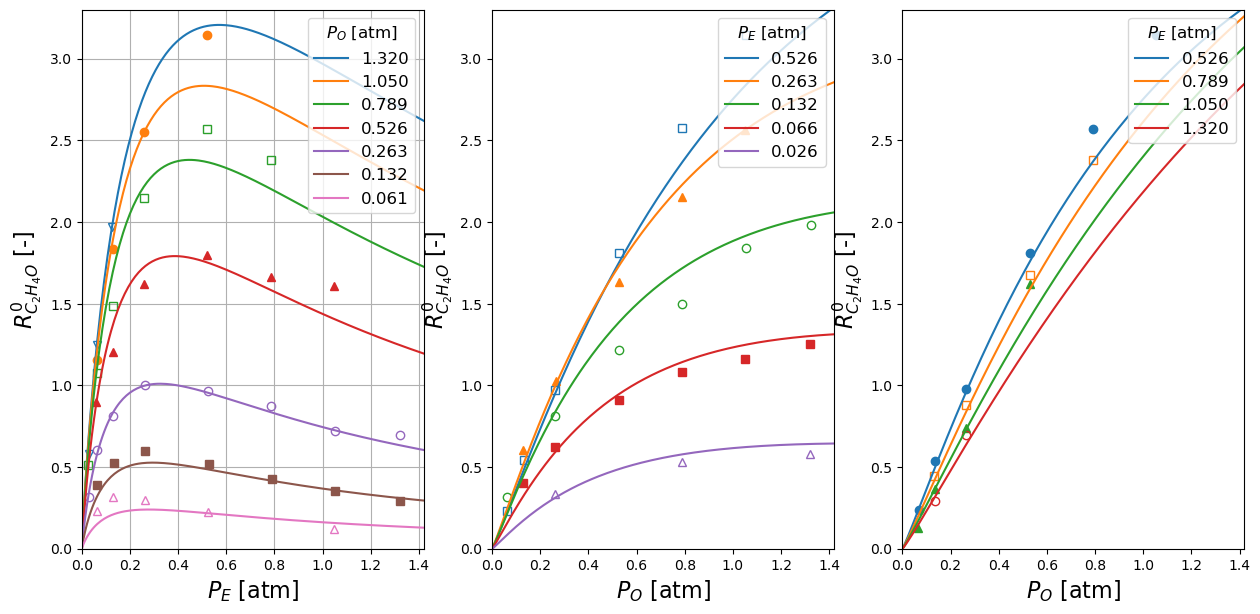

In [19]:
# Rate of production of ethylene oxide at various pressures of ethylene & oxygen — experiment & theory:
plt.figure(figsize=(15, 7))

# Compare to Figs. 3 & 12
plt.subplot(1, 3, 1)
Po = array([1.32, 1.05, 0.789, 0.526, 0.263, 0.132, 0.061])
Pe = [[0.0283, 0.0632, 0.1265],  # Po = 1.32 atm
      [0.0616, 0.1281, 0.2596, 0.5191],  # Po = 1.05 atm
      [0.0266, 0.0616, 0.1298, 0.2596, 0.5208, 0.7837],  # Po = 0.789 atm
      [0.0582, 0.1314, 0.2596, 0.5208, 0.7854, 1.0466],  # Po = 0.526 atm
      [0.0300, 0.0649, 0.1314, 0.2612, 0.5258, 0.7870, 1.0516, 1.3228],  # Po = 0.263 atm
      [0.0632, 0.1348, 0.2612, 0.5275, 0.7887, 1.0516, 1.3211],  # Po = 0.132 atm
      [0.0616, 0.1298, 0.2629, 0.5225, 1.0483]]  # Po = 0.061 atm
R0 = [[0.5811, 1.2467, 1.9719],  # Po = 1.32 atm
      [1.1540, 1.8328, 2.5513, 3.1440],  # Po = 1.05 atm
      [0.5149, 1.0745, 1.4851, 2.1474, 2.5679, 2.3791],  # Po = 0.789 atm
      [0.8990, 1.2070, 1.6209, 1.7997, 1.6672, 1.6076],  # Po = 0.526 atm
      [0.3195, 0.6076, 0.8162, 1.0050, 0.9652, 0.8725, 0.7202, 0.6970],  # Po = 0.263 atm
      [0.3907, 0.5232, 0.5960, 0.5199, 0.4305, 0.3560, 0.2930],  # Po = 0.132 atm
      [0.2318, 0.3146, 0.2980, 0.2252, 0.1192]]  # Po = 0.61 atm      
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    plt.plot(Pe[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe = linspace(0, 1.42, 200)  # atm
R0 = empty((Po.shape[0], Pe.shape[0]))
for i in range(Po.shape[0]):
    G = array([log(Pe    / Pe0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po[i] + Cp)),
               log(Po[i] / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po[i] + Cp))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Pe, R0[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe[0], Pe[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.grid(True)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 4
plt.subplot(1, 3, 2) 
Pe = array([0.526, 0.263, 0.132, 0.066, 0.026])
Po = [[0.0598, 0.1312, 0.2625, 0.5266, 0.7890, 1.0548],  # Pe = 0.526 atm
      [0.1296, 0.2641, 0.5249, 0.7890, 1.0498],  # Pe = 0.263 atm
      [0.0598, 0.2608, 0.5249, 0.7890, 1.0532, 1.3239],  # Pe = 0.132 atm
      [0.1279, 0.2625, 0.5249, 0.7890, 1.0515, 1.3189],  # Pe = 0.066 atm
      [0.2608, 0.7874, 1.3189]]  # Pe = 0.026 atm
R0 = [[0.2289, 0.5417, 0.9731, 1.8128, 2.5735, 3.1465],  # Pe = 0.526 atm
      [0.6043, 1.0258, 1.6317, 2.1520, 2.5670],  # Pe = 0.263 atm
      [0.3178, 0.8150, 1.2168, 1.4967, 1.8425, 1.9808],  # Pe = 0.132 atm
      [0.4001, 0.6240, 0.9138, 1.0851, 1.1608, 1.2530],  # Pe = 0.066 atm
      [0.3342, 0.5318, 0.5812]]  # Pe = 0.026 atm
marker = ['s', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe[i] + Ko * Po + Cp)),
               log(Po    / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe[i] + Ko * Po + Cp))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 5
plt.subplot(1, 3, 3) 
Pe = array([0.526, 0.789, 1.05, 1.32])
Po = [[0.0669, 0.1355, 0.2659, 0.5286, 0.7928, 1.0538],  # Pe = 0.526 atm
      [0.1321, 0.2659, 0.5286, 0.7912],  # Pe = 0.789 atm
      [0.0652, 0.1338, 0.2659, 0.5319],  # Pe = 1.05 atm
      [0.1355, 0.2659]]  # Pe = 1.32 atm
R0 = [[0.2384, 0.5364, 0.9801, 1.8113, 2.5695, 3.1457],  # Pe = 0.526 atm
      [0.4437, 0.8808, 1.6788, 2.3775],  # Pe = 0.789 atm
      [0.1291, 0.3642, 0.7384, 1.6192],  # Pe = 1.05 atm
      [0.2947, 0.6954]]  # Pe = 1.32 atm
marker = ['o', 's', '^', 'o']
face = [None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)  # atm
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe[i] + Ko * Po + Cp)),
               log(Po    / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe[i] + Ko * Po + Cp))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right');

## Try: all sites, atomic-oxygen adsorption, Eley-Rideal (ethylene in gas), variable-order rxn.

In [20]:
Pe = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po = expt_df['Pres. O2 [atm]'].to_numpy()
y = expt_df['rel. rate C2H4O [-]'].to_numpy()
Pe0 = 0.263
Po0 = 0.263
Ke = 2.7
Ko = 12.4
Cp = 0.14
G = array([log(Pe / Pe0),
     0.5 * log(Po / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe + sqrt(Ko * Po) + Cp))]).T
x = solve(G.T @ G, G.T @ log(y))
print(x)

[0.74559168 2.95246338]


In [21]:
Pe = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po = expt_df['Pres. O2 [atm]'].to_numpy()
y = expt_df['rel. rate C2H4O [-]'].to_numpy()
ne = y.shape[0]
# @jit(nopython=True)
def nln_post(ϕ):
    Ke = ϕ[0]
    Ko = ϕ[1]
    Cp = ϕ[2]
    σ = ϕ[3]
    # Prior
    nln_prior = log(σ)
    # Likelihood
    G = empty((ne, 2))
    G = array([log(Pe / Pe0),
         0.5 * log(Po / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe + sqrt(Ko * Po) + Cp))]).T
    Λ, V = eigh(G.T @ G)
    xbar = V @ (((log(y).T @ G) @ V) / Λ).T
    ln_detGTG = log(Λ).sum()
    δ = log(y) - G @ xbar
    nln_likelihood = 0.5 * (ln_detGTG + δ.T @ δ / σ**2) + (ne - 3) * log(σ)
    # Posterior
    nln_posterior = nln_prior + nln_likelihood
    return nln_posterior
ϕ_guess = array([1.0, 1.0, 0.1, 0.3])
# nln_post(ϕ_guess)

out = minimize(nln_post, ϕ_guess, bounds=((1e-8, None),)*4, method='Nelder-Mead', options=dict(maxiter=1000))
for term in ['success', 'message', 'x', 'fun']:
    print(term, out[term])

success True
message Optimization terminated successfully.
x [ 2.73006167 12.39465472  0.14123239  0.08896909]
fun -136.95530832540683


In [22]:
Pe0 = 0.263
Po0 = 0.263
Ke = 2.7
Ko = 12.4
Cp = 0.14
xbar = array([0.75, 3.0])

/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/535621650.py:29: RuntimeWarning: divide by zero encountered in log
  G = array([log(Pe    / Pe0),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/535621650.py:63: RuntimeWarning: divide by zero encountered in log
  0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe[i] + sqrt(Ko * Po) + Cp))]).T
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/535621650.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  G = array([log(Pe[i] / Pe0),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/535621650.py:93: RuntimeWarning: divide by zero encountered in log
  0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * P

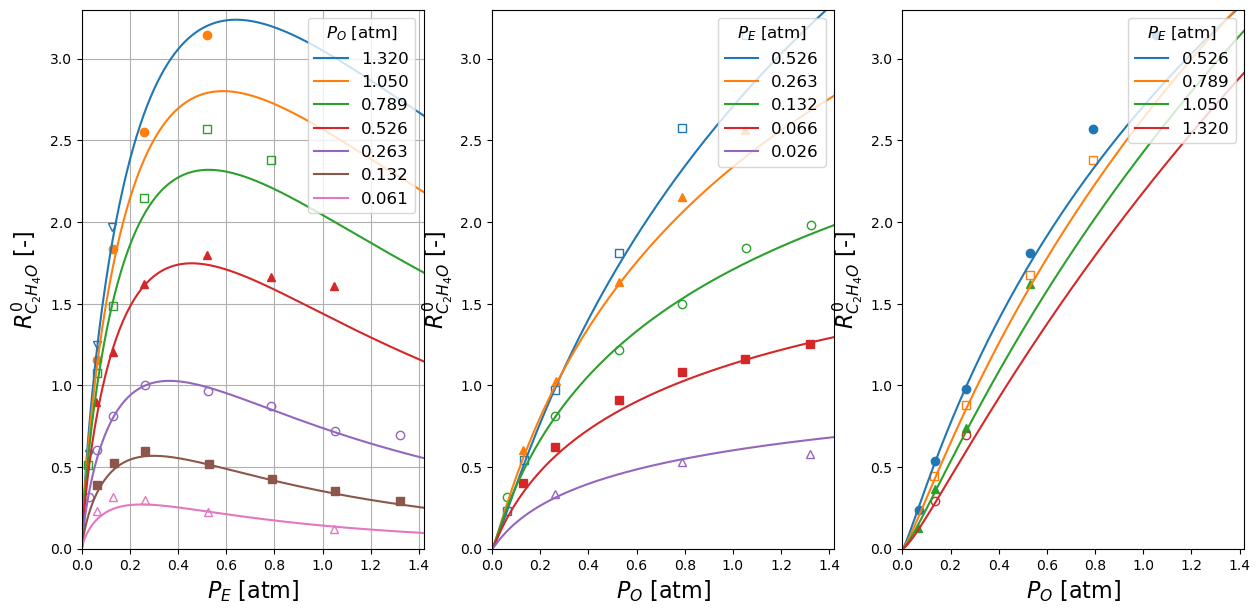

In [23]:
# Rate of production of ethylene oxide at various pressures of ethylene & oxygen — experiment & theory:
plt.figure(figsize=(15, 7))

# Compare to Figs. 3 & 12
plt.subplot(1, 3, 1)
Po = array([1.32, 1.05, 0.789, 0.526, 0.263, 0.132, 0.061])
Pe = [[0.0283, 0.0632, 0.1265],  # Po = 1.32 atm
      [0.0616, 0.1281, 0.2596, 0.5191],  # Po = 1.05 atm
      [0.0266, 0.0616, 0.1298, 0.2596, 0.5208, 0.7837],  # Po = 0.789 atm
      [0.0582, 0.1314, 0.2596, 0.5208, 0.7854, 1.0466],  # Po = 0.526 atm
      [0.0300, 0.0649, 0.1314, 0.2612, 0.5258, 0.7870, 1.0516, 1.3228],  # Po = 0.263 atm
      [0.0632, 0.1348, 0.2612, 0.5275, 0.7887, 1.0516, 1.3211],  # Po = 0.132 atm
      [0.0616, 0.1298, 0.2629, 0.5225, 1.0483]]  # Po = 0.061 atm
R0 = [[0.5811, 1.2467, 1.9719],  # Po = 1.32 atm
      [1.1540, 1.8328, 2.5513, 3.1440],  # Po = 1.05 atm
      [0.5149, 1.0745, 1.4851, 2.1474, 2.5679, 2.3791],  # Po = 0.789 atm
      [0.8990, 1.2070, 1.6209, 1.7997, 1.6672, 1.6076],  # Po = 0.526 atm
      [0.3195, 0.6076, 0.8162, 1.0050, 0.9652, 0.8725, 0.7202, 0.6970],  # Po = 0.263 atm
      [0.3907, 0.5232, 0.5960, 0.5199, 0.4305, 0.3560, 0.2930],  # Po = 0.132 atm
      [0.2318, 0.3146, 0.2980, 0.2252, 0.1192]]  # Po = 0.61 atm      
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    plt.plot(Pe[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe = linspace(0, 1.42, 200)  # atm
R0 = empty((Po.shape[0], Pe.shape[0]))
for i in range(Po.shape[0]):
    G = array([log(Pe    / Pe0),
         0.5 * log(Po[i] / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe + sqrt(Ko * Po[i]) + Cp))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Pe, R0[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe[0], Pe[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.grid(True)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 4
plt.subplot(1, 3, 2) 
Pe = array([0.526, 0.263, 0.132, 0.066, 0.026])
Po = [[0.0598, 0.1312, 0.2625, 0.5266, 0.7890, 1.0548],  # Pe = 0.526 atm
      [0.1296, 0.2641, 0.5249, 0.7890, 1.0498],  # Pe = 0.263 atm
      [0.0598, 0.2608, 0.5249, 0.7890, 1.0532, 1.3239],  # Pe = 0.132 atm
      [0.1279, 0.2625, 0.5249, 0.7890, 1.0515, 1.3189],  # Pe = 0.066 atm
      [0.2608, 0.7874, 1.3189]]  # Pe = 0.026 atm
R0 = [[0.2289, 0.5417, 0.9731, 1.8128, 2.5735, 3.1465],  # Pe = 0.526 atm
      [0.6043, 1.0258, 1.6317, 2.1520, 2.5670],  # Pe = 0.263 atm
      [0.3178, 0.8150, 1.2168, 1.4967, 1.8425, 1.9808],  # Pe = 0.132 atm
      [0.4001, 0.6240, 0.9138, 1.0851, 1.1608, 1.2530],  # Pe = 0.066 atm
      [0.3342, 0.5318, 0.5812]]  # Pe = 0.026 atm
marker = ['s', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0),
         0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe[i] + sqrt(Ko * Po) + Cp))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 5
plt.subplot(1, 3, 3) 
Pe = array([0.526, 0.789, 1.05, 1.32])
Po = [[0.0669, 0.1355, 0.2659, 0.5286, 0.7928, 1.0538],  # Pe = 0.526 atm
      [0.1321, 0.2659, 0.5286, 0.7912],  # Pe = 0.789 atm
      [0.0652, 0.1338, 0.2659, 0.5319],  # Pe = 1.05 atm
      [0.1355, 0.2659]]  # Pe = 1.32 atm
R0 = [[0.2384, 0.5364, 0.9801, 1.8113, 2.5695, 3.1457],  # Pe = 0.526 atm
      [0.4437, 0.8808, 1.6788, 2.3775],  # Pe = 0.789 atm
      [0.1291, 0.3642, 0.7384, 1.6192],  # Pe = 1.05 atm
      [0.2947, 0.6954]]  # Pe = 1.32 atm
marker = ['o', 's', '^', 'o']
face = [None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)  # atm
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0),
         0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe[i] + sqrt(Ko * Po) + Cp))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right');

## Try: all sites, molecular-oxygen adsorption, Eley-Rideal, variable-order rxn.

In [24]:
Pe = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po = expt_df['Pres. O2 [atm]'].to_numpy()
y = expt_df['rel. rate C2H4O [-]'].to_numpy()
Pe0 = 0.263
Po0 = 0.263
Ke = 18
Ko = 12
Cp = 0.0
G = array([log(Pe / Pe0),
           log(Po / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po + Cp))]).T
x = solve(G.T @ G, G.T @ log(y))
print(x)

[0.74839612 1.29540175]


In [25]:
Pe = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po = expt_df['Pres. O2 [atm]'].to_numpy()
y = expt_df['rel. rate C2H4O [-]'].to_numpy()
ne = y.shape[0]
# @jit(nopython=True)
def nln_post(ϕ):
    Ke = ϕ[0]
    Ko = ϕ[1]
    Cp = ϕ[2]
    σ = ϕ[3]
    # Prior
    nln_prior = log(σ)
    # Likelihood
    G = empty((ne, 2))
    G[:, 0] = log(Pe / Pe0)
    G[:, 1] = log(Po / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po + Cp))
    Λ, V = eigh(G.T @ G)
    xbar = V @ (((log(y).T @ G) @ V) / Λ).T
    ln_detGTG = log(Λ).sum()
    δ = log(y) - G @ xbar
    nln_likelihood = 0.5 * (ln_detGTG + δ.T @ δ / σ**2) + (ne - 3) * log(σ)
    # Posterior
    nln_posterior = nln_prior + nln_likelihood
    return nln_posterior
ϕ_guess = array([1.0, 1.0, 0.1, 0.3])
# nln_post(ϕ_guess)

out = minimize(nln_post, ϕ_guess, bounds=((1e-8, None),)*4, method='Nelder-Mead', options=dict(maxiter=1000))
for term in ['success', 'message', 'x', 'fun']:
    print(term, out[term])

success True
message Optimization terminated successfully.
x [1.82191542e+01 1.24443258e+01 1.00000000e-08 1.12074711e-01]
fun -119.28993033295852


In [26]:
Pe0 = 0.263
Po0 = 0.263
Ke = 18
Ko = 12
Cp = 0.0
xbar = array([0.75, 1.3])

/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3089024221.py:29: RuntimeWarning: divide by zero encountered in log
  G = array([log(Pe    / Pe0),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3089024221.py:63: RuntimeWarning: divide by zero encountered in log
  log(Po    / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe[i] + Ko * Po + Cp))]).T
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3089024221.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  G = array([log(Pe[i] / Pe0),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/3089024221.py:93: RuntimeWarning: divide by zero encountered in log
  log(Po    / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe[i] + Ko * Po + Cp))]).T


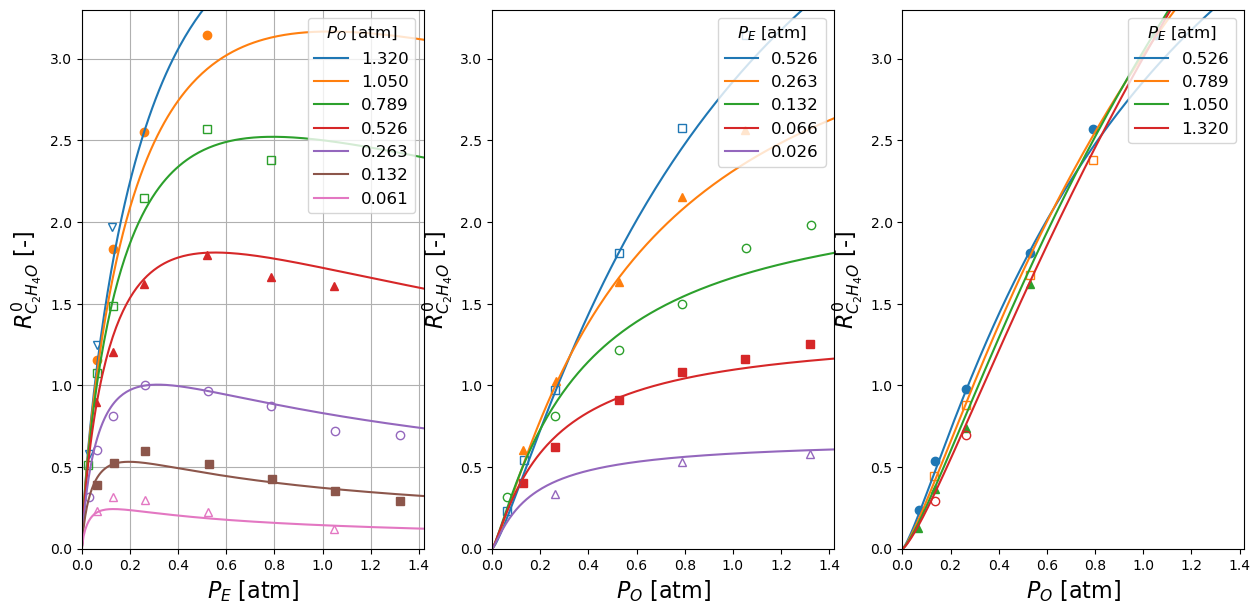

In [27]:
# Rate of production of ethylene oxide at various pressures of ethylene & oxygen — experiment & theory:
plt.figure(figsize=(15, 7))

# Compare to Figs. 3 & 12
plt.subplot(1, 3, 1)
Po = array([1.32, 1.05, 0.789, 0.526, 0.263, 0.132, 0.061])
Pe = [[0.0283, 0.0632, 0.1265],  # Po = 1.32 atm
      [0.0616, 0.1281, 0.2596, 0.5191],  # Po = 1.05 atm
      [0.0266, 0.0616, 0.1298, 0.2596, 0.5208, 0.7837],  # Po = 0.789 atm
      [0.0582, 0.1314, 0.2596, 0.5208, 0.7854, 1.0466],  # Po = 0.526 atm
      [0.0300, 0.0649, 0.1314, 0.2612, 0.5258, 0.7870, 1.0516, 1.3228],  # Po = 0.263 atm
      [0.0632, 0.1348, 0.2612, 0.5275, 0.7887, 1.0516, 1.3211],  # Po = 0.132 atm
      [0.0616, 0.1298, 0.2629, 0.5225, 1.0483]]  # Po = 0.061 atm
R0 = [[0.5811, 1.2467, 1.9719],  # Po = 1.32 atm
      [1.1540, 1.8328, 2.5513, 3.1440],  # Po = 1.05 atm
      [0.5149, 1.0745, 1.4851, 2.1474, 2.5679, 2.3791],  # Po = 0.789 atm
      [0.8990, 1.2070, 1.6209, 1.7997, 1.6672, 1.6076],  # Po = 0.526 atm
      [0.3195, 0.6076, 0.8162, 1.0050, 0.9652, 0.8725, 0.7202, 0.6970],  # Po = 0.263 atm
      [0.3907, 0.5232, 0.5960, 0.5199, 0.4305, 0.3560, 0.2930],  # Po = 0.132 atm
      [0.2318, 0.3146, 0.2980, 0.2252, 0.1192]]  # Po = 0.61 atm      
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    plt.plot(Pe[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe = linspace(0, 1.42, 200)  # atm
R0 = empty((Po.shape[0], Pe.shape[0]))
for i in range(Po.shape[0]):
    G = array([log(Pe    / Pe0),
               log(Po[i] / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe + Ko * Po[i] + Cp))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Pe, R0[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe[0], Pe[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.grid(True)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 4
plt.subplot(1, 3, 2) 
Pe = array([0.526, 0.263, 0.132, 0.066, 0.026])
Po = [[0.0598, 0.1312, 0.2625, 0.5266, 0.7890, 1.0548],  # Pe = 0.526 atm
      [0.1296, 0.2641, 0.5249, 0.7890, 1.0498],  # Pe = 0.263 atm
      [0.0598, 0.2608, 0.5249, 0.7890, 1.0532, 1.3239],  # Pe = 0.132 atm
      [0.1279, 0.2625, 0.5249, 0.7890, 1.0515, 1.3189],  # Pe = 0.066 atm
      [0.2608, 0.7874, 1.3189]]  # Pe = 0.026 atm
R0 = [[0.2289, 0.5417, 0.9731, 1.8128, 2.5735, 3.1465],  # Pe = 0.526 atm
      [0.6043, 1.0258, 1.6317, 2.1520, 2.5670],  # Pe = 0.263 atm
      [0.3178, 0.8150, 1.2168, 1.4967, 1.8425, 1.9808],  # Pe = 0.132 atm
      [0.4001, 0.6240, 0.9138, 1.0851, 1.1608, 1.2530],  # Pe = 0.066 atm
      [0.3342, 0.5318, 0.5812]]  # Pe = 0.026 atm
marker = ['s', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0),
               log(Po    / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe[i] + Ko * Po + Cp))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 5
plt.subplot(1, 3, 3) 
Pe = array([0.526, 0.789, 1.05, 1.32])
Po = [[0.0669, 0.1355, 0.2659, 0.5286, 0.7928, 1.0538],  # Pe = 0.526 atm
      [0.1321, 0.2659, 0.5286, 0.7912],  # Pe = 0.789 atm
      [0.0652, 0.1338, 0.2659, 0.5319],  # Pe = 1.05 atm
      [0.1355, 0.2659]]  # Pe = 1.32 atm
R0 = [[0.2384, 0.5364, 0.9801, 1.8113, 2.5695, 3.1457],  # Pe = 0.526 atm
      [0.4437, 0.8808, 1.6788, 2.3775],  # Pe = 0.789 atm
      [0.1291, 0.3642, 0.7384, 1.6192],  # Pe = 1.05 atm
      [0.2947, 0.6954]]  # Pe = 1.32 atm
marker = ['o', 's', '^', 'o']
face = [None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)  # atm
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0),
               log(Po    / Po0) + log((1 + Ke * Pe0 + Ko * Po0 + Cp) / (1 + Ke * Pe[i] + Ko * Po + Cp))]).T
    R0[i] = exp(G @ xbar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right');

# Also, with complete oxidation

## Try: all sites, atomic-oxygen adsorption, Eley-Rideal/simple-Langmuir, variable-order rxns.

In [28]:
Pe1 = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po1 = expt_df['Pres. O2 [atm]'].to_numpy()
y1 = expt_df['rel. rate C2H4O [-]'].to_numpy()
expt_df2 = expt_df[expt_df['rel. rate CO2 [-]'].notnull()]
Pe2 = expt_df2['Pres. C2H4 [atm]'].to_numpy()
Po2 = expt_df2['Pres. O2 [atm]'].to_numpy()
y2 = expt_df2['rel. rate CO2 [-]'].to_numpy()
Pe0 = 0.263
Po0 = 0.263
Ke = 2.305
Ko = 6.506
Cp = 0.0
G1 = array([log(Pe1 / Pe0),
      0.5 * log(Po1 / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe1 + sqrt(Ko * Po1) + Cp))]).T
x1 = solve(G1.T @ G1, G1.T @ log(y1))
print(x1)
G2 = array([log(Pe2 / Pe0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe2 + sqrt(Ko * Po2) + Cp)),
      0.5 * log(Po2 / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe2 + sqrt(Ko * Po2) + Cp))]).T
x2 = solve(G2.T @ G2, G2.T @ log(y2))
print(x2)

[0.74942429 2.77019179]
[0.72452702 2.89541755]


In [29]:
ne1 = y1.shape[0]
ne2 = y2.shape[0]
# @jit(nopython=True)
def nln_post(ϕ):
    Ke = ϕ[0]
    Ko = ϕ[1]
    Cp = ϕ[2]
    σ = ϕ[3]
    # Prior
    nln_prior = log(σ)
    # Likelihood
    G1 = empty((ne1, 2))
    G1[:, 0] =       log(Pe1 / Pe0)
    G1[:, 1] = 0.5 * log(Po1 / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe1 + sqrt(Ko * Po1) + Cp))
    Λ1, V1 = eigh(G1.T @ G1)
    x1bar = V1 @ (((log(y1).T @ G1) @ V1) / Λ1).T
    ln_detGTG1 = log(Λ1).sum()
    δ1 = log(y1) - G1 @ x1bar
    G2 = empty((ne2, 2))
    G2[:, 0] =       log(Pe2 / Pe0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe2 + sqrt(Ko * Po2) + Cp))
    G2[:, 1] = 0.5 * log(Po2 / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe2 + sqrt(Ko * Po2) + Cp))
    Λ2, V2 = eigh(G2.T @ G2)
    x2bar = V2 @ (((log(y2).T @ G2) @ V2) / Λ2).T
    ln_detGTG2 = log(Λ2).sum()
    δ2 = log(y2) - G2 @ x2bar
    nln_likelihood = 0.5 * (ln_detGTG1 + δ1.T @ δ1 / σ**2 + ln_detGTG2 + δ2.T @ δ2 / σ**2) + (ne1 + ne2 - 4) * log(σ)
    # Posterior
    nln_posterior = nln_prior + nln_likelihood
    return nln_posterior
ϕ_guess = array([1.0, 1.0, 0.1, 0.3])
# nln_post(ϕ_guess)

out = minimize(nln_post, ϕ_guess, bounds=((1e-8, None),)*4, method='Nelder-Mead', options=dict(maxiter=1000))
for term in ['success', 'message', 'x', 'fun']:
    print(term, out[term])

success True
message Optimization terminated successfully.
x [2.30537936e+00 6.50643346e+00 1.00000000e-08 1.17328765e-01]
fun -176.67657366394636


In [30]:
Ke = 2.305
Ko = 6.506
Cp = 0.0
x1bar = [0.749, 2.77]
x2bar = [0.725, 2.90]

/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/2173427902.py:29: RuntimeWarning: divide by zero encountered in log
  G = array([log(Pe    / Pe0),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/2173427902.py:63: RuntimeWarning: divide by zero encountered in log
  0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe[i] + sqrt(Ko * Po) + Cp))]).T
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/2173427902.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  G = array([log(Pe[i] / Pe0),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/2173427902.py:93: RuntimeWarning: divide by zero encountered in log
  0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke

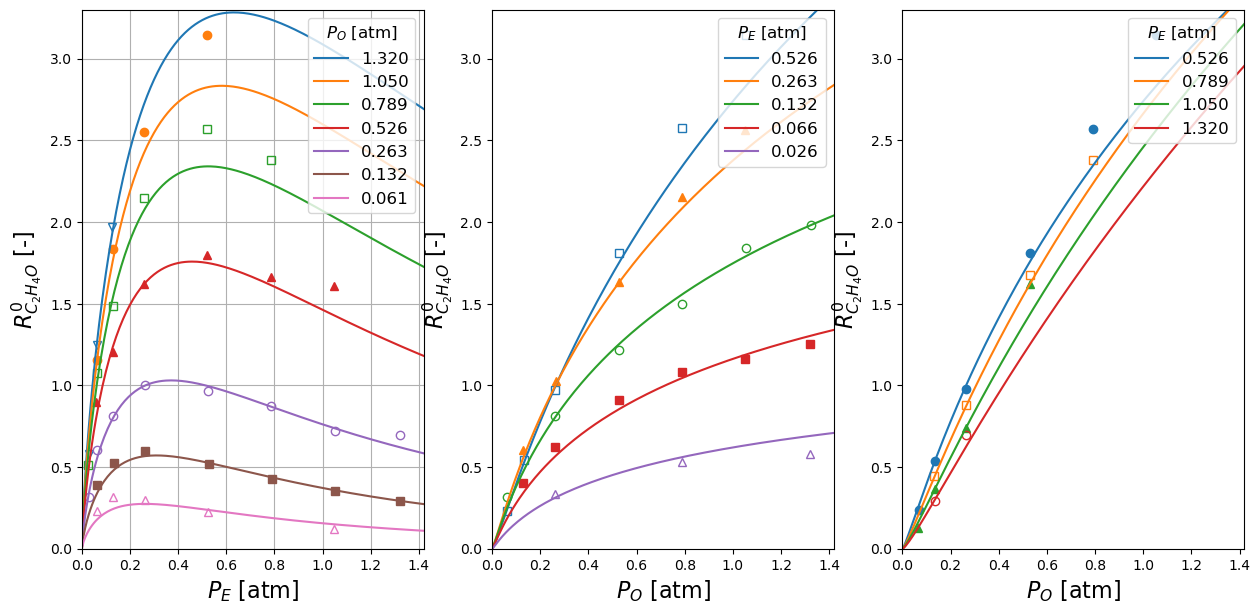

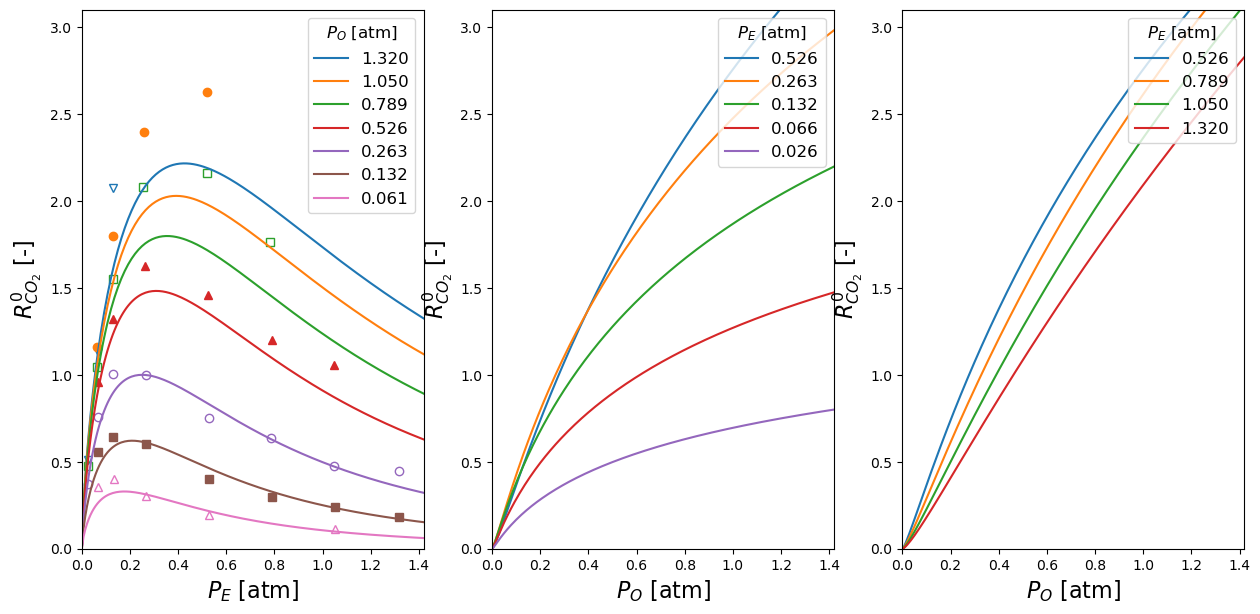

In [31]:
# Rate of production of ethylene oxide at various pressures of ethylene & oxygen — experiment & theory:
plt.figure(figsize=(15, 7))

# Compare to Figs. 3 & 12
plt.subplot(1, 3, 1)
Po = array([1.32, 1.05, 0.789, 0.526, 0.263, 0.132, 0.061])
Pe = [[0.0283, 0.0632, 0.1265],  # Po = 1.32 atm
      [0.0616, 0.1281, 0.2596, 0.5191],  # Po = 1.05 atm
      [0.0266, 0.0616, 0.1298, 0.2596, 0.5208, 0.7837],  # Po = 0.789 atm
      [0.0582, 0.1314, 0.2596, 0.5208, 0.7854, 1.0466],  # Po = 0.526 atm
      [0.0300, 0.0649, 0.1314, 0.2612, 0.5258, 0.7870, 1.0516, 1.3228],  # Po = 0.263 atm
      [0.0632, 0.1348, 0.2612, 0.5275, 0.7887, 1.0516, 1.3211],  # Po = 0.132 atm
      [0.0616, 0.1298, 0.2629, 0.5225, 1.0483]]  # Po = 0.061 atm
R0 = [[0.5811, 1.2467, 1.9719],  # Po = 1.32 atm
      [1.1540, 1.8328, 2.5513, 3.1440],  # Po = 1.05 atm
      [0.5149, 1.0745, 1.4851, 2.1474, 2.5679, 2.3791],  # Po = 0.789 atm
      [0.8990, 1.2070, 1.6209, 1.7997, 1.6672, 1.6076],  # Po = 0.526 atm
      [0.3195, 0.6076, 0.8162, 1.0050, 0.9652, 0.8725, 0.7202, 0.6970],  # Po = 0.263 atm
      [0.3907, 0.5232, 0.5960, 0.5199, 0.4305, 0.3560, 0.2930],  # Po = 0.132 atm
      [0.2318, 0.3146, 0.2980, 0.2252, 0.1192]]  # Po = 0.61 atm      
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    plt.plot(Pe[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe = linspace(0, 1.42, 200)  # atm
R0 = empty((Po.shape[0], Pe.shape[0]))
for i in range(Po.shape[0]):
    G = array([log(Pe    / Pe0),
         0.5 * log(Po[i] / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe + sqrt(Ko * Po[i]) + Cp))]).T
    R0[i] = exp(G @ x1bar)
    plt.plot(Pe, R0[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe[0], Pe[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.grid(True)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 4
plt.subplot(1, 3, 2) 
Pe = array([0.526, 0.263, 0.132, 0.066, 0.026])
Po = [[0.0598, 0.1312, 0.2625, 0.5266, 0.7890, 1.0548],  # Pe = 0.526 atm
      [0.1296, 0.2641, 0.5249, 0.7890, 1.0498],  # Pe = 0.263 atm
      [0.0598, 0.2608, 0.5249, 0.7890, 1.0532, 1.3239],  # Pe = 0.132 atm
      [0.1279, 0.2625, 0.5249, 0.7890, 1.0515, 1.3189],  # Pe = 0.066 atm
      [0.2608, 0.7874, 1.3189]]  # Pe = 0.026 atm
R0 = [[0.2289, 0.5417, 0.9731, 1.8128, 2.5735, 3.1465],  # Pe = 0.526 atm
      [0.6043, 1.0258, 1.6317, 2.1520, 2.5670],  # Pe = 0.263 atm
      [0.3178, 0.8150, 1.2168, 1.4967, 1.8425, 1.9808],  # Pe = 0.132 atm
      [0.4001, 0.6240, 0.9138, 1.0851, 1.1608, 1.2530],  # Pe = 0.066 atm
      [0.3342, 0.5318, 0.5812]]  # Pe = 0.026 atm
marker = ['s', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0),
         0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe[i] + sqrt(Ko * Po) + Cp))]).T
    R0[i] = exp(G @ x1bar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 5
plt.subplot(1, 3, 3) 
Pe = array([0.526, 0.789, 1.05, 1.32])
Po = [[0.0669, 0.1355, 0.2659, 0.5286, 0.7928, 1.0538],  # Pe = 0.526 atm
      [0.1321, 0.2659, 0.5286, 0.7912],  # Pe = 0.789 atm
      [0.0652, 0.1338, 0.2659, 0.5319],  # Pe = 1.05 atm
      [0.1355, 0.2659]]  # Pe = 1.32 atm
R0 = [[0.2384, 0.5364, 0.9801, 1.8113, 2.5695, 3.1457],  # Pe = 0.526 atm
      [0.4437, 0.8808, 1.6788, 2.3775],  # Pe = 0.789 atm
      [0.1291, 0.3642, 0.7384, 1.6192],  # Pe = 1.05 atm
      [0.2947, 0.6954]]  # Pe = 1.32 atm
marker = ['o', 's', '^', 'o']
face = [None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)  # atm
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0),
         0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe[i] + sqrt(Ko * Po) + Cp))]).T
    R0[i] = exp(G @ x1bar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right');

# Rate of production of carbon dioxide at various pressures of ethylene & oxygen — experiment & theory:
plt.figure(figsize=(15, 7))

# Compare to Figs: 6 & 14
plt.subplot(1, 3, 1)
Po = array([1.32, 1.05, 0.789, 0.526, 0.263, 0.132, 0.061])
Pe = [[0.0274, 0.0670, 0.1309],  # Po = 1.32 atm
      [0.0639, 0.1309, 0.2587, 0.5204],  # Po = 1.05 atm
      [0.0274, 0.0639, 0.1309, 0.2557, 0.5204, 0.7822],  # Pi = 0.789 atm
      [0.0670, 0.1309, 0.2617, 0.5235, 0.7883, 1.0470],  # Po = 0.526 atm
      [0.0274, 0.0670, 0.1309, 0.2648, 0.5265, 0.7852, 1.0470, 1.3178],  # Po = 0.263 atm
      [0.0670, 0.1309, 0.2678, 0.5265, 0.7883, 1.0500, 1.3178],  # Po = 0.132 atm
      [0.0670, 0.1339, 0.2648, 0.5265, 1.05]]  # Po = 0.061 atm
R0 = [[0.5082, 1.1327, 2.0755],  # Po = 1.32 atm
      [1.1633, 1.8000, 2.4000, 2.6265],  # Po = 1.05 atm
      [0.4776, 1.0469, 1.5490, 2.0816, 2.1612, 1.7633],  # Po = 0.789 atm
      [0.9612, 1.3224, 1.6286, 1.4571, 1.2000, 1.0592],  # Po = 0.526 atm
      [0.3735, 0.7592, 1.0041, 0.9980, 0.7531, 0.6367, 0.4776, 0.4469],  # Po = 0.263 atm
      [0.5571, 0.6429, 0.6000, 0.4041, 0.3000, 0.2388, 0.1837],  # Po = 0.132 atm
      [0.3551, 0.4041, 0.3061, 0.1959, 0.1163]]  # Po = 0.061 atm
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    plt.plot(Pe[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe = linspace(0, 1.42, 200)  # atm
R0 = empty((Po.shape[0], Pe.shape[0]))
for i in range(Po.shape[0]):
    G = array([log(Pe    / Pe0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe + sqrt(Ko * Po[i]) + Cp)),
         0.5 * log(Po[i] / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe + sqrt(Ko * Po[i]) + Cp))]).T
    R0[i] = exp(G @ x2bar)
    plt.plot(Pe, R0[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe[0], Pe[-1])
plt.ylim(0, 3.1)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{CO_2}$ [-]', fontsize=16)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

plt.subplot(1, 3, 2) 
Po = linspace(0, 1.42, 200)  # atm
Pe = array([0.526, 0.263, 0.132, 0.066, 0.026])
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0),
         0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe[i] + sqrt(Ko * Po) + Cp))]).T
    R0[i] = exp(G @ x2bar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.1)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{CO_2}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

plt.subplot(1, 3, 3) 
Po = linspace(0, 1.42, 200)  # atm
Pe = array([0.526, 0.789, 1.05, 1.32])
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0),
         0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe[i] + sqrt(Ko * Po) + Cp))]).T
    R0[i] = exp(G @ x2bar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.1)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{CO_2}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right');

## Try: all sites, atomic-oxygen adsorption, Eley-Rideal/Eley-Rideal, variable-order rxns.

In [32]:
Pe1 = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po1 = expt_df['Pres. O2 [atm]'].to_numpy()
y1 = expt_df['rel. rate C2H4O [-]'].to_numpy()
expt_df2 = expt_df[expt_df['rel. rate CO2 [-]'].notnull()]
Pe2 = expt_df2['Pres. C2H4 [atm]'].to_numpy()
Po2 = expt_df2['Pres. O2 [atm]'].to_numpy()
y2 = expt_df2['rel. rate CO2 [-]'].to_numpy()
Pe0 = 0.263
Po0 = 0.263
Ke = 22.4
Ko = 27.3
Cp = 0.0
G1 = array([log(Pe1 / Pe0),
      0.5 * log(Po1 / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe1 + sqrt(Ko * Po1) + Cp))]).T
x1 = solve(G1.T @ G1, G1.T @ log(y1))
print(x1)
G2 = array([log(Pe2 / Pe0),
      0.5 * log(Po2 / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe2 + sqrt(Ko * Po2) + Cp))]).T
x2 = solve(G2.T @ G2, G2.T @ log(y2))
print(x2)

[1.29813684 2.12023175]
[1.19882318 2.17243074]


In [33]:
ne1 = y1.shape[0]
ne2 = y2.shape[0]
# @jit(nopython=True)
def nln_post(ϕ):
    Ke = ϕ[0]
    Ko = ϕ[1]
    Cp = ϕ[2]
    σ = ϕ[3]
    # Prior
    nln_prior = log(σ)
    # Likelihood
    G1 = empty((ne1, 2))
    G1[:, 0] =       log(Pe1 / Pe0)
    G1[:, 1] = 0.5 * log(Po1 / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe1 + sqrt(Ko * Po1) + Cp))
    Λ1, V1 = eigh(G1.T @ G1)
    x1bar = V1 @ (((log(y1).T @ G1) @ V1) / Λ1).T
    ln_detGTG1 = log(Λ1).sum()
    δ1 = log(y1) - G1 @ x1bar
    G2 = empty((ne2, 2))
    G2[:, 0] =       log(Pe2 / Pe0)
    G2[:, 1] = 0.5 * log(Po2 / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe2 + sqrt(Ko * Po2) + Cp))
    Λ2, V2 = eigh(G2.T @ G2)
    x2bar = V2 @ (((log(y2).T @ G2) @ V2) / Λ2).T
    ln_detGTG2 = log(Λ2).sum()
    δ2 = log(y2) - G2 @ x2bar
    nln_likelihood = 0.5 * (ln_detGTG1 + δ1.T @ δ1 / σ**2 + ln_detGTG2 + δ2.T @ δ2 / σ**2) + (ne1 + ne2 - 4) * log(σ)
    # Posterior
    nln_posterior = nln_prior + nln_likelihood
    return nln_posterior
ϕ_guess = array([1.0, 1.0, 0.1, 0.3])
# nln_post(ϕ_guess)

out = minimize(nln_post, ϕ_guess, bounds=((1e-8, None),)*4, method='Nelder-Mead', options=dict(maxiter=1000))
for term in ['success', 'message', 'x', 'fun']:
    print(term, out[term])

success True
message Optimization terminated successfully.
x [2.24728867e+01 2.73097658e+01 1.00000000e-08 1.16504030e-01]
fun -176.80248559258678


In [34]:
Ke = 22
Ko = 27
Cp = 0.0
x1bar = [1.3, 2.1]
x2bar = [1.2, 2.2]

/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/1398891449.py:29: RuntimeWarning: divide by zero encountered in log
  G = array([log(Pe    / Pe0),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/1398891449.py:63: RuntimeWarning: divide by zero encountered in log
  0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe[i] + sqrt(Ko * Po) + Cp))]).T
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/1398891449.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  G = array([log(Pe[i] / Pe0),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/1398891449.py:93: RuntimeWarning: divide by zero encountered in log
  0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke

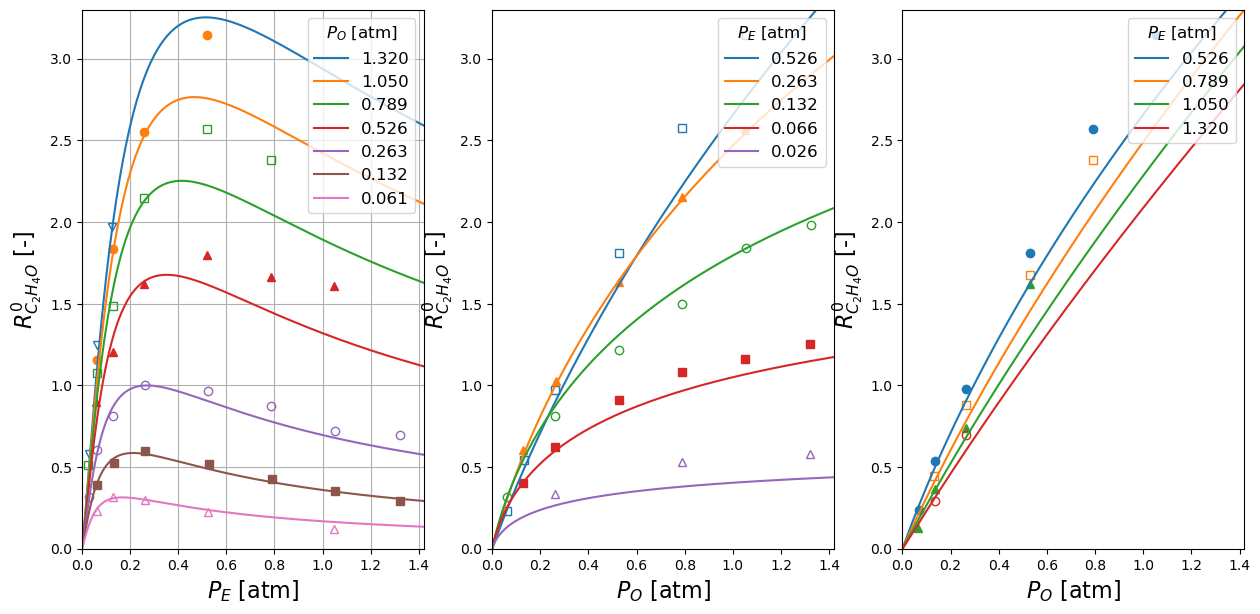

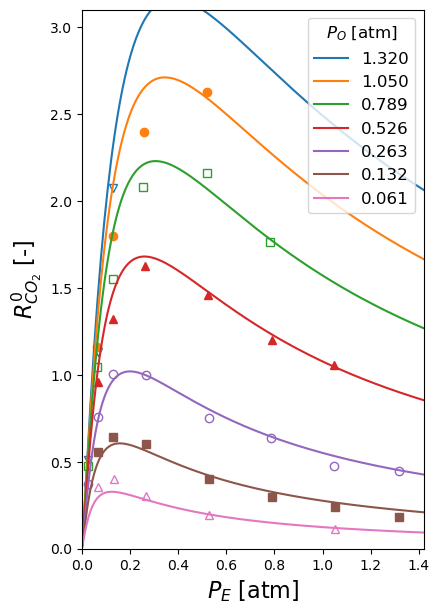

In [35]:
# Rate of production of ethylene oxide at various pressures of ethylene & oxygen — experiment & theory:
plt.figure(figsize=(15, 7))

# Compare to Figs. 3 & 12
plt.subplot(1, 3, 1)
Po = array([1.32, 1.05, 0.789, 0.526, 0.263, 0.132, 0.061])
Pe = [[0.0283, 0.0632, 0.1265],  # Po = 1.32 atm
      [0.0616, 0.1281, 0.2596, 0.5191],  # Po = 1.05 atm
      [0.0266, 0.0616, 0.1298, 0.2596, 0.5208, 0.7837],  # Po = 0.789 atm
      [0.0582, 0.1314, 0.2596, 0.5208, 0.7854, 1.0466],  # Po = 0.526 atm
      [0.0300, 0.0649, 0.1314, 0.2612, 0.5258, 0.7870, 1.0516, 1.3228],  # Po = 0.263 atm
      [0.0632, 0.1348, 0.2612, 0.5275, 0.7887, 1.0516, 1.3211],  # Po = 0.132 atm
      [0.0616, 0.1298, 0.2629, 0.5225, 1.0483]]  # Po = 0.061 atm
R0 = [[0.5811, 1.2467, 1.9719],  # Po = 1.32 atm
      [1.1540, 1.8328, 2.5513, 3.1440],  # Po = 1.05 atm
      [0.5149, 1.0745, 1.4851, 2.1474, 2.5679, 2.3791],  # Po = 0.789 atm
      [0.8990, 1.2070, 1.6209, 1.7997, 1.6672, 1.6076],  # Po = 0.526 atm
      [0.3195, 0.6076, 0.8162, 1.0050, 0.9652, 0.8725, 0.7202, 0.6970],  # Po = 0.263 atm
      [0.3907, 0.5232, 0.5960, 0.5199, 0.4305, 0.3560, 0.2930],  # Po = 0.132 atm
      [0.2318, 0.3146, 0.2980, 0.2252, 0.1192]]  # Po = 0.61 atm      
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    plt.plot(Pe[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe = linspace(0, 1.42, 200)  # atm
R0 = empty((Po.shape[0], Pe.shape[0]))
for i in range(Po.shape[0]):
    G = array([log(Pe    / Pe0),
         0.5 * log(Po[i] / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe + sqrt(Ko * Po[i]) + Cp))]).T
    R0[i] = exp(G @ x1bar)
    plt.plot(Pe, R0[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe[0], Pe[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.grid(True)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 4
plt.subplot(1, 3, 2) 
Pe = array([0.526, 0.263, 0.132, 0.066, 0.026])
Po = [[0.0598, 0.1312, 0.2625, 0.5266, 0.7890, 1.0548],  # Pe = 0.526 atm
      [0.1296, 0.2641, 0.5249, 0.7890, 1.0498],  # Pe = 0.263 atm
      [0.0598, 0.2608, 0.5249, 0.7890, 1.0532, 1.3239],  # Pe = 0.132 atm
      [0.1279, 0.2625, 0.5249, 0.7890, 1.0515, 1.3189],  # Pe = 0.066 atm
      [0.2608, 0.7874, 1.3189]]  # Pe = 0.026 atm
R0 = [[0.2289, 0.5417, 0.9731, 1.8128, 2.5735, 3.1465],  # Pe = 0.526 atm
      [0.6043, 1.0258, 1.6317, 2.1520, 2.5670],  # Pe = 0.263 atm
      [0.3178, 0.8150, 1.2168, 1.4967, 1.8425, 1.9808],  # Pe = 0.132 atm
      [0.4001, 0.6240, 0.9138, 1.0851, 1.1608, 1.2530],  # Pe = 0.066 atm
      [0.3342, 0.5318, 0.5812]]  # Pe = 0.026 atm
marker = ['s', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0),
         0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe[i] + sqrt(Ko * Po) + Cp))]).T
    R0[i] = exp(G @ x1bar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 5
plt.subplot(1, 3, 3) 
Pe = array([0.526, 0.789, 1.05, 1.32])
Po = [[0.0669, 0.1355, 0.2659, 0.5286, 0.7928, 1.0538],  # Pe = 0.526 atm
      [0.1321, 0.2659, 0.5286, 0.7912],  # Pe = 0.789 atm
      [0.0652, 0.1338, 0.2659, 0.5319],  # Pe = 1.05 atm
      [0.1355, 0.2659]]  # Pe = 1.32 atm
R0 = [[0.2384, 0.5364, 0.9801, 1.8113, 2.5695, 3.1457],  # Pe = 0.526 atm
      [0.4437, 0.8808, 1.6788, 2.3775],  # Pe = 0.789 atm
      [0.1291, 0.3642, 0.7384, 1.6192],  # Pe = 1.05 atm
      [0.2947, 0.6954]]  # Pe = 1.32 atm
marker = ['o', 's', '^', 'o']
face = [None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)  # atm
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0),
         0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe[i] + sqrt(Ko * Po) + Cp))]).T
    R0[i] = exp(G @ x1bar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right');

# Rate of production of carbon dioxide at various pressures of ethylene & oxygen — experiment & theory:
plt.figure(figsize=(15, 7))

# Compare to Figs: 6 & 14
plt.subplot(1, 3, 1)
Po = array([1.32, 1.05, 0.789, 0.526, 0.263, 0.132, 0.061])
Pe = [[0.0274, 0.0670, 0.1309],  # Po = 1.32 atm
      [0.0639, 0.1309, 0.2587, 0.5204],  # Po = 1.05 atm
      [0.0274, 0.0639, 0.1309, 0.2557, 0.5204, 0.7822],  # Pi = 0.789 atm
      [0.0670, 0.1309, 0.2617, 0.5235, 0.7883, 1.0470],  # Po = 0.526 atm
      [0.0274, 0.0670, 0.1309, 0.2648, 0.5265, 0.7852, 1.0470, 1.3178],  # Po = 0.263 atm
      [0.0670, 0.1309, 0.2678, 0.5265, 0.7883, 1.0500, 1.3178],  # Po = 0.132 atm
      [0.0670, 0.1339, 0.2648, 0.5265, 1.05]]  # Po = 0.061 atm
R0 = [[0.5082, 1.1327, 2.0755],  # Po = 1.32 atm
      [1.1633, 1.8000, 2.4000, 2.6265],  # Po = 1.05 atm
      [0.4776, 1.0469, 1.5490, 2.0816, 2.1612, 1.7633],  # Po = 0.789 atm
      [0.9612, 1.3224, 1.6286, 1.4571, 1.2000, 1.0592],  # Po = 0.526 atm
      [0.3735, 0.7592, 1.0041, 0.9980, 0.7531, 0.6367, 0.4776, 0.4469],  # Po = 0.263 atm
      [0.5571, 0.6429, 0.6000, 0.4041, 0.3000, 0.2388, 0.1837],  # Po = 0.132 atm
      [0.3551, 0.4041, 0.3061, 0.1959, 0.1163]]  # Po = 0.061 atm
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    plt.plot(Pe[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe = linspace(0, 1.42, 200)  # atm
R0 = empty((Po.shape[0], Pe.shape[0]))
for i in range(Po.shape[0]):
    G = array([log(Pe    / Pe0),
         0.5 * log(Po[i] / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe + sqrt(Ko * Po[i]) + Cp))]).T
    R0[i] = exp(G @ x2bar)
    plt.plot(Pe, R0[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe[0], Pe[-1])
plt.ylim(0, 3.1)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{CO_2}$ [-]', fontsize=16)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# plt.subplot(1, 3, 2) 
# Po = linspace(0, 1.42, 200)  # atm
# Pe = array([0.526, 0.263, 0.132, 0.066, 0.026])
# R0 = empty((Pe.shape[0], Po.shape[0]))
# for i in range(Pe.shape[0]):
#     R0[i] = R0_CO2(Pe[i], Po)
#     plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
# plt.xlim(Po[0], Po[-1])
# plt.ylim(0, 3.1)
# plt.xlabel('$P_O$ [atm]', fontsize=16)
# plt.ylabel('$R^0_{CO_2}$ [-]', fontsize=16)
# plt.legend(title='$P_E$ [atm]', title_fontsize=12,
#            fontsize=12, loc='upper right')

# plt.subplot(1, 3, 3) 
# Po = linspace(0, 1.42, 200)  # atm
# Pe = array([0.526, 0.789, 1.05, 1.32])
# R0 = empty((Pe.shape[0], Po.shape[0]))
# for i in range(Pe.shape[0]):
#     R0[i] = R0_CO2(Pe[i], Po)
#     plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
# plt.xlim(Po[0], Po[-1])
# plt.ylim(0, 3.1)
# plt.xlabel('$P_O$ [atm]', fontsize=16)
# plt.ylabel('$R^0_{CO_2}$ [-]', fontsize=16)
# plt.legend(title='$P_E$ [atm]', title_fontsize=12,
#            fontsize=12, loc='upper right');

## Try: all sites, atomic-oxygen adsorption, Eley-Rideal/combination, variable-order rxns.

In [36]:
Pe1 = expt_df['Pres. C2H4 [atm]'].to_numpy()
Po1 = expt_df['Pres. O2 [atm]'].to_numpy()
y1 = expt_df['rel. rate C2H4O [-]'].to_numpy()
expt_df2 = expt_df[expt_df['rel. rate CO2 [-]'].notnull()]
Pe2 = expt_df2['Pres. C2H4 [atm]'].to_numpy()
Po2 = expt_df2['Pres. O2 [atm]'].to_numpy()
y2 = expt_df2['rel. rate CO2 [-]'].to_numpy()
Pe0 = 0.263
Po0 = 0.263
Ke = 25.6
Ko = 21.5
Cp = 0.02
G1 = array([log(Pe1 / Pe0),
      0.5 * log(Po1 / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe1 + sqrt(Ko * Po1) + Cp))]).T
x1 = solve(G1.T @ G1, G1.T @ log(y1))
print(x1)
G2 = array([log(Pe2 / Pe0),
      0.5 * log(Po2 / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe2 + sqrt(Ko * Po2) + Cp)),
            log(Po2 / Po0)]).T
x2 = solve(G2.T @ G2, G2.T @ log(y2))
print(x2)

[1.36939729 2.06841432]
[ 1.46281028  2.50018087 -0.20969953]


In [37]:
ne1 = y1.shape[0]
ne2 = y2.shape[0]
# @jit(nopython=True)
def nln_post(ϕ):
    Ke = ϕ[0]
    Ko = ϕ[1]
    Cp = ϕ[2]
    σ = ϕ[3]
    # Prior
    nln_prior = log(σ)
    # Likelihood
    G1 = empty((ne1, 2))
    G1[:, 0] =       log(Pe1 / Pe0)
    G1[:, 1] = 0.5 * log(Po1 / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe1 + sqrt(Ko * Po1) + Cp))
    Λ1, V1 = eigh(G1.T @ G1)
    x1bar = V1 @ (((log(y1).T @ G1) @ V1) / Λ1).T
    ln_detGTG1 = log(Λ1).sum()
    δ1 = log(y1) - G1 @ x1bar
    G2 = empty((ne2, 3))
    G2[:, 0] =       log(Pe2 / Pe0)
    G2[:, 1] = 0.5 * log(Po2 / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe2 + sqrt(Ko * Po2) + Cp))
    G2[:, 2] =       log(Po2 / Po0)
    Λ2, V2 = eigh(G2.T @ G2)
    x2bar = V2 @ (((log(y2).T @ G2) @ V2) / Λ2).T
    ln_detGTG2 = log(Λ2).sum()
    δ2 = log(y2) - G2 @ x2bar
    nln_likelihood = 0.5 * (ln_detGTG1 + δ1.T @ δ1 / σ**2 + ln_detGTG2 + δ2.T @ δ2 / σ**2) + (ne1 + ne2 - 4) * log(σ)
    # Posterior
    nln_posterior = nln_prior + nln_likelihood
    return nln_posterior
ϕ_guess = array([1.0, 1.0, 0.1, 0.3])
# nln_post(ϕ_guess)

out = minimize(nln_post, ϕ_guess, bounds=((1e-8, None),)*4, method='Nelder-Mead', options=dict(maxiter=1000))
for term in ['success', 'message', 'x', 'fun']:
    print(term, out[term])

success True
message Optimization terminated successfully.
x [2.56053257e+01 2.14915098e+01 2.22541240e-02 9.80533909e-02]
fun -194.5412614056077


In [38]:
Ke = 25.6
Ko = 21.5
Cp = 0.02
x1bar = [1.37, 2.07]
x2bar = [1.46, 2.50, -0.21]

/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/283858156.py:29: RuntimeWarning: divide by zero encountered in log
  G = array([log(Pe    / Pe0),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/283858156.py:63: RuntimeWarning: divide by zero encountered in log
  0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe[i] + sqrt(Ko * Po) + Cp))]).T
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/283858156.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  G = array([log(Pe[i] / Pe0),
/var/folders/p3/c22_sgkj2mg8s9dsq8dcbm9h000jxm/T/ipykernel_59611/283858156.py:93: RuntimeWarning: divide by zero encountered in log
  0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * P

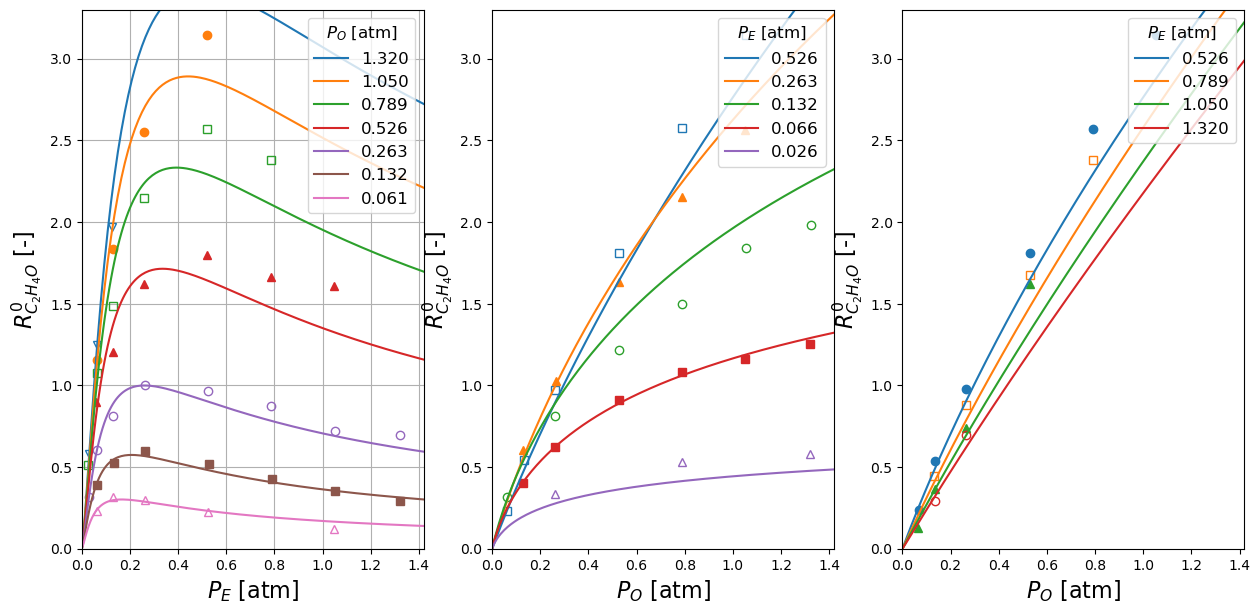

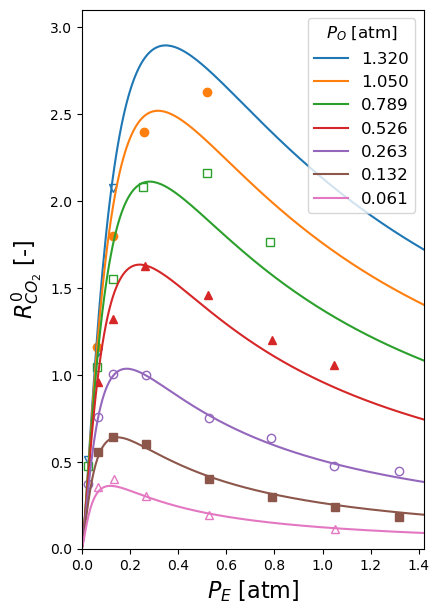

In [39]:
# Rate of production of ethylene oxide at various pressures of ethylene & oxygen — experiment & theory:
plt.figure(figsize=(15, 7))

# Compare to Figs. 3 & 12
plt.subplot(1, 3, 1)
Po = array([1.32, 1.05, 0.789, 0.526, 0.263, 0.132, 0.061])
Pe = [[0.0283, 0.0632, 0.1265],  # Po = 1.32 atm
      [0.0616, 0.1281, 0.2596, 0.5191],  # Po = 1.05 atm
      [0.0266, 0.0616, 0.1298, 0.2596, 0.5208, 0.7837],  # Po = 0.789 atm
      [0.0582, 0.1314, 0.2596, 0.5208, 0.7854, 1.0466],  # Po = 0.526 atm
      [0.0300, 0.0649, 0.1314, 0.2612, 0.5258, 0.7870, 1.0516, 1.3228],  # Po = 0.263 atm
      [0.0632, 0.1348, 0.2612, 0.5275, 0.7887, 1.0516, 1.3211],  # Po = 0.132 atm
      [0.0616, 0.1298, 0.2629, 0.5225, 1.0483]]  # Po = 0.061 atm
R0 = [[0.5811, 1.2467, 1.9719],  # Po = 1.32 atm
      [1.1540, 1.8328, 2.5513, 3.1440],  # Po = 1.05 atm
      [0.5149, 1.0745, 1.4851, 2.1474, 2.5679, 2.3791],  # Po = 0.789 atm
      [0.8990, 1.2070, 1.6209, 1.7997, 1.6672, 1.6076],  # Po = 0.526 atm
      [0.3195, 0.6076, 0.8162, 1.0050, 0.9652, 0.8725, 0.7202, 0.6970],  # Po = 0.263 atm
      [0.3907, 0.5232, 0.5960, 0.5199, 0.4305, 0.3560, 0.2930],  # Po = 0.132 atm
      [0.2318, 0.3146, 0.2980, 0.2252, 0.1192]]  # Po = 0.61 atm      
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    plt.plot(Pe[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe = linspace(0, 1.42, 200)  # atm
R0 = empty((Po.shape[0], Pe.shape[0]))
for i in range(Po.shape[0]):
    G = array([log(Pe    / Pe0),
         0.5 * log(Po[i] / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe + sqrt(Ko * Po[i]) + Cp))]).T
    R0[i] = exp(G @ x1bar)
    plt.plot(Pe, R0[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe[0], Pe[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.grid(True)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 4
plt.subplot(1, 3, 2) 
Pe = array([0.526, 0.263, 0.132, 0.066, 0.026])
Po = [[0.0598, 0.1312, 0.2625, 0.5266, 0.7890, 1.0548],  # Pe = 0.526 atm
      [0.1296, 0.2641, 0.5249, 0.7890, 1.0498],  # Pe = 0.263 atm
      [0.0598, 0.2608, 0.5249, 0.7890, 1.0532, 1.3239],  # Pe = 0.132 atm
      [0.1279, 0.2625, 0.5249, 0.7890, 1.0515, 1.3189],  # Pe = 0.066 atm
      [0.2608, 0.7874, 1.3189]]  # Pe = 0.026 atm
R0 = [[0.2289, 0.5417, 0.9731, 1.8128, 2.5735, 3.1465],  # Pe = 0.526 atm
      [0.6043, 1.0258, 1.6317, 2.1520, 2.5670],  # Pe = 0.263 atm
      [0.3178, 0.8150, 1.2168, 1.4967, 1.8425, 1.9808],  # Pe = 0.132 atm
      [0.4001, 0.6240, 0.9138, 1.0851, 1.1608, 1.2530],  # Pe = 0.066 atm
      [0.3342, 0.5318, 0.5812]]  # Pe = 0.026 atm
marker = ['s', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0),
         0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe[i] + sqrt(Ko * Po) + Cp))]).T
    R0[i] = exp(G @ x1bar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# Compare to Fig. 5
plt.subplot(1, 3, 3) 
Pe = array([0.526, 0.789, 1.05, 1.32])
Po = [[0.0669, 0.1355, 0.2659, 0.5286, 0.7928, 1.0538],  # Pe = 0.526 atm
      [0.1321, 0.2659, 0.5286, 0.7912],  # Pe = 0.789 atm
      [0.0652, 0.1338, 0.2659, 0.5319],  # Pe = 1.05 atm
      [0.1355, 0.2659]]  # Pe = 1.32 atm
R0 = [[0.2384, 0.5364, 0.9801, 1.8113, 2.5695, 3.1457],  # Pe = 0.526 atm
      [0.4437, 0.8808, 1.6788, 2.3775],  # Pe = 0.789 atm
      [0.1291, 0.3642, 0.7384, 1.6192],  # Pe = 1.05 atm
      [0.2947, 0.6954]]  # Pe = 1.32 atm
marker = ['o', 's', '^', 'o']
face = [None, 'none', None, 'none']
for i in range(Pe.shape[0]):
    plt.plot(Po[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po = linspace(0, 1.42, 200)  # atm
R0 = empty((Pe.shape[0], Po.shape[0]))
for i in range(Pe.shape[0]):
    G = array([log(Pe[i] / Pe0),
         0.5 * log(Po    / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe[i] + sqrt(Ko * Po) + Cp))]).T
    R0[i] = exp(G @ x1bar)
    plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
plt.xlim(Po[0], Po[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right');

# Rate of production of carbon dioxide at various pressures of ethylene & oxygen — experiment & theory:
plt.figure(figsize=(15, 7))

# Compare to Figs: 6 & 14
plt.subplot(1, 3, 1)
Po = array([1.32, 1.05, 0.789, 0.526, 0.263, 0.132, 0.061])
Pe = [[0.0274, 0.0670, 0.1309],  # Po = 1.32 atm
      [0.0639, 0.1309, 0.2587, 0.5204],  # Po = 1.05 atm
      [0.0274, 0.0639, 0.1309, 0.2557, 0.5204, 0.7822],  # Pi = 0.789 atm
      [0.0670, 0.1309, 0.2617, 0.5235, 0.7883, 1.0470],  # Po = 0.526 atm
      [0.0274, 0.0670, 0.1309, 0.2648, 0.5265, 0.7852, 1.0470, 1.3178],  # Po = 0.263 atm
      [0.0670, 0.1309, 0.2678, 0.5265, 0.7883, 1.0500, 1.3178],  # Po = 0.132 atm
      [0.0670, 0.1339, 0.2648, 0.5265, 1.05]]  # Po = 0.061 atm
R0 = [[0.5082, 1.1327, 2.0755],  # Po = 1.32 atm
      [1.1633, 1.8000, 2.4000, 2.6265],  # Po = 1.05 atm
      [0.4776, 1.0469, 1.5490, 2.0816, 2.1612, 1.7633],  # Po = 0.789 atm
      [0.9612, 1.3224, 1.6286, 1.4571, 1.2000, 1.0592],  # Po = 0.526 atm
      [0.3735, 0.7592, 1.0041, 0.9980, 0.7531, 0.6367, 0.4776, 0.4469],  # Po = 0.263 atm
      [0.5571, 0.6429, 0.6000, 0.4041, 0.3000, 0.2388, 0.1837],  # Po = 0.132 atm
      [0.3551, 0.4041, 0.3061, 0.1959, 0.1163]]  # Po = 0.061 atm
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    plt.plot(Pe[i], R0[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe = linspace(0, 1.42, 200)  # atm
R0 = empty((Po.shape[0], Pe.shape[0]))
for i in range(Po.shape[0]):
    G = array([log(Pe    / Pe0),
         0.5 * log(Po[i] / Po0) + log((1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp) / (1 + Ke * Pe + sqrt(Ko * Po[i]) + Cp)),
               log(Po[i] / Po0)]).T
    R0[i] = exp(G @ x2bar)
    plt.plot(Pe, R0[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe[0], Pe[-1])
plt.ylim(0, 3.1)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{CO_2}$ [-]', fontsize=16)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

# plt.subplot(1, 3, 2) 
# Po = linspace(0, 1.42, 200)  # atm
# Pe = array([0.526, 0.263, 0.132, 0.066, 0.026])
# R0 = empty((Pe.shape[0], Po.shape[0]))
# for i in range(Pe.shape[0]):
#     R0[i] = R0_CO2(Pe[i], Po)
#     plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
# plt.xlim(Po[0], Po[-1])
# plt.ylim(0, 3.1)
# plt.xlabel('$P_O$ [atm]', fontsize=16)
# plt.ylabel('$R^0_{CO_2}$ [-]', fontsize=16)
# plt.legend(title='$P_E$ [atm]', title_fontsize=12,
#            fontsize=12, loc='upper right')

# plt.subplot(1, 3, 3) 
# Po = linspace(0, 1.42, 200)  # atm
# Pe = array([0.526, 0.789, 1.05, 1.32])
# R0 = empty((Pe.shape[0], Po.shape[0]))
# for i in range(Pe.shape[0]):
#     R0[i] = R0_CO2(Pe[i], Po)
#     plt.plot(Po, R0[i], label=f'{Pe[i]:.3f}')
# plt.xlim(Po[0], Po[-1])
# plt.ylim(0, 3.1)
# plt.xlabel('$P_O$ [atm]', fontsize=16)
# plt.ylabel('$R^0_{CO_2}$ [-]', fontsize=16)
# plt.legend(title='$P_E$ [atm]', title_fontsize=12,
#            fontsize=12, loc='upper right');

# De-normalizing (from relative rates for a specific surface area, to a widely usable expression)
Although the data in Klugherz has been normalized, they reported a baseline rate at the reference/standard conditions. This allows determination of the rate coefficients for de-normalizing the rate expressions.
\begin{equation}
k_i^{\text{area basis}} = \frac{r_{i, \text{reported}}^{\text{mass basis}} \big|_{P_{e, 0}, P_{o, 0}}}{S \theta_{e, 0}^{n_e} \theta_{o, 0}^{n_o}}
\end{equation}
where $S$ is the reported specific surface area.

In [40]:
reo_reported = ((6 + 7) / 2) * 1e-6 / 60  # C2H4O rxn. rate [moles C2H4 / (s g-cat.)]
rc_reported = ((4 + 6) / 2) * 1e-6 / 60  # CO2 rxn. rate [moles C2H4 / (s g-cat.)]
S = 0.5  # specific surface area [m^2 / g-cat.]

## For: all sites, molecular-oxygen adsorption, simple Langmuir, variable-order rxn.

In [41]:
Pe0 = 0.263
Po0 = 0.263
Ke = 3.3
Ko = 0.97
Cp = 0.1
ne = 0.852
no = 1.054

F0 = 1 + Ke * Pe0 + Ko * Po0 + Cp
θe0 = Ke * Pe0 / F0
θo0 = Ko * Po0 / F0
keo = reo_reported / (S * θe0**ne * θo0**no)  # [mol-rxn. / (s m^2-cat.)]

def rate(Pe, Po):
    """
    Calculate the C2H4O reaction rate [mol / (s * m^2-cat.)] from reactant pressures [bar].
    """
    F = 1 + Ke * Pe + Ko * Po + Cp
    θe = Ke * Pe / F
    θo = Ko * Po / F
    r = keo * θe**ne * θo**no
    return r
print(S * rate(Pe0, Po0) * 60)

6.499999999999999e-06


## For: all sites, atomic-oxygen adsorption, Eley-Rideal/simple-Langmuir, variable-order rxns.

In [42]:
Pe0 = 0.263
Po0 = 0.263
Ke = 2.3
Ko = 6.5
Cp = 0.0
n1e = 0.749
n1o = 2.771
n2e = 0.724
n2o = 2.897

F0 = 1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp
θe0 = Pe0
θo0 = sqrt(Ko * Po0) / F0
keo = reo_reported / (S * θe0**n1e * θo0**n1o)  # [mol-rxn. / (s m^2-cat.)]
print(keo)
θe0 = Ke * Pe0 / F0
θo0 = sqrt(Ko * Po0) / F0
kc = rc_reported / (S * θe0**n2e * θo0**n2o)
print(kc)

def rate(Pe, Po):
    """
    Calculate the C2H4O reaction rate [mol / (s * m^2-cat.)] from reactant pressures [bar].
    """
    F = 1 + Ke * Pe + sqrt(Ko * Po) + Cp
    θe = Pe
    θo = sqrt(Ko * Po) / F
    r1 = keo * θe**n1e * θo**n1o
    θe = Ke * Pe / F
    θo = sqrt(Ko * Po) / F
    r2 = kc * θe**n2e * θo**n2o
    return array([r1, r2])
print(S * rate(Pe0, Po0) * 60)

5.420455654037483e-06
5.292249038950301e-06
[6.5e-06 5.0e-06]


## For: all sites, atomic-oxygen adsorption, Eley-Rideal/Eley-Rideal, variable-order rxns.

In [44]:
Pe0 = 0.263
Po0 = 0.263
Ke = 22.4
Ko = 27.3
Cp = 0.0
n1e = 1.30
n1o = 2.12
n2e = 1.20
n2o = 2.17

F0 = 1 + Ke * Pe0 + sqrt(Ko * Po0) + Cp
θe0 = Pe0
θo0 = sqrt(Ko * Po0) / F0
keo = reo_reported / (S * θe0**n1e * θo0**n1o)  # [mol-rxn. / (s m^2-cat.)]
print(keo)
θe0 = Pe0
θo0 = sqrt(Ko * Po0) / F0
kc = rc_reported / (S * θe0**n2e * θo0**n2o)
print(kc)

def rate(Pe, Po):
    """
    Calculate the C2H4O reaction rate [mol / (s * m^2-cat.)] from reactant pressures [bar].
    """
    F = 1 + Ke * Pe + sqrt(Ko * Po) + Cp
    θe = Pe
    θo = sqrt(Ko * Po) / F
    r1 = keo * θe**n1e * θo**n1o
    θe = Pe
    θo = sqrt(Ko * Po) / F
    r2 = kc * θe**n2e * θo**n2o
    return array([r1, r2])
print(S * rate(Pe0, Po0) * 60)

1.8279655515329947e-05
1.3111866869445382e-05
[6.5e-06 5.0e-06]


# Theile Effect

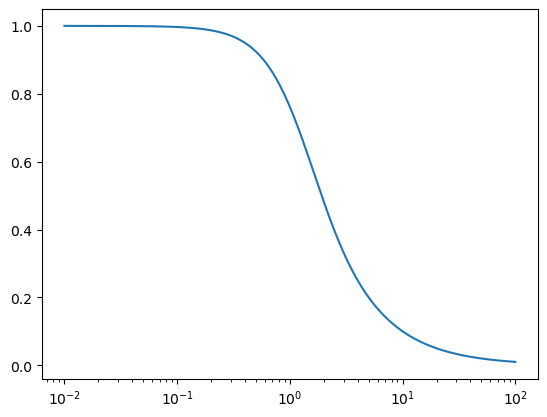

In [43]:
# Side note: Theile modulus for 1st order reactions
from numpy import logspace, tanh
hT = logspace(-2, 2, 200)
ϵ = tanh(hT) / hT
plt.semilogx(hT, ϵ) ;